In [47]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import os
import subprocess
import time
import pandas as pd
import pickle
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
from matplotlib.colors import LinearSegmentedColormap
import sys
import re
from concurrent.futures import ProcessPoolExecutor

In [2]:
sns.set_style('ticks')
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.labelspacing'] = 0.2
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['lines.scale_dashes'] = False
mpl.rcParams['lines.dashed_pattern'] = (2, 1)
#mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['text.color'] = 'k'

## General functions

In [3]:
def standardize_plot_graphics(ax):
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, **kwargs):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], **kwargs)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', linecolor='r', markersize=3,
                            show_pval=True):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)   
    if show_pval:
        plot_label = '%s p=%.2e\nr=%.3f'% (plot_label, pvalue, np.sign(slope)*np.sqrt(R2))
    else:
        plot_label = '%s r=%.3f'% (plot_label, np.sign(slope)*np.sqrt(R2))
    ax.scatter(x, y, color=color, label=plot_label, s=markersize)
    ax.plot(temp, temppred, color=linecolor)
    return ax, slope, pvalue, R2

# Data preprocess with Ephys data (only run this first time)

## Normalized to -3 to -1s (100ms bins)

In [4]:
base_dir = "./Cana CPP Data"

databin = 0.001
BinSize = 0.1
TimeRange = 6
TotalBins = int(TimeRange/BinSize)

baseline_start = 3
baseline_duration = 2

In [5]:
# Load the csv files for each animal into a dictionary

files = os.listdir(base_dir)

csv_files = [file for file in files if (file.endswith('.csv')) & (file[0].isdigit())]

animal_ids = []
for csv_file in csv_files:
    if csv_file[:2] == '10':
        animal_id = csv_file[:4]
    else:
        animal_id = csv_file[:3]
    animal_ids.append(animal_id) 

# Load the csv files for each animal into a dictionary
animal_data = {}
for csv_file, animal_id in zip(csv_files, animal_ids):
    filename = os.path.join(base_dir, csv_file)
    animal_data[animal_id] = pd.read_csv(filename)

In [6]:
# Load the csv file with cross timepoints
interval_data = pd.read_csv(os.path.join(base_dir,"CPP Intervals_Corrected June 2023.csv"))
interval_data = interval_data.drop(interval_data[interval_data['Start'] == 0].index)
interval_data.Session.unique()

array(['Pref_Paired', 'Pref_Neutral', 'Confl_Paired', 'Confl_Neutral'],
      dtype=object)

In [7]:
length = np.zeros(len(animal_data))
for i, animal_id in enumerate(animal_ids):
    length[i] = animal_data[animal_id].shape[0]


In [8]:
%%time
def process_intervals(interval_data, TimeRange, trace, animal_dt, animalids, databin, TotalBins):
    start = interval_data["Start"] - 0.5 * TimeRange
    startidx = np.searchsorted(animal_dt["Bin Left"], start, side='right')
    endidx = startidx + int(TimeRange / databin)
    
    n_bins = int(TimeRange / databin)
    tracenew = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins))

    # Calculate the mean and std for baseline
    n_bins_base = int(baseline_duration/databin)
    tracebase = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins_base))
    start_base = interval_data["Start"] -  baseline_start
    base_startidx = np.searchsorted(animal_dt["Bin Left"], start_base, side='right')
    baseline_end_idx = start_base + n_bins_base
    for i in range(n_bins_base):
        tracebase.iloc[:,i] = trace.iloc[:, base_startidx+i].mean(axis=1)
    baseline_mean = tracebase.mean(axis=1)
    baseline_std = tracebase.std(axis=1)
        
    for i in range(n_bins):
        tracenew.iloc[:,i] = trace.iloc[:,startidx+i].mean(axis=1)

    tracebin = tracenew.groupby(pd.cut(tracenew.columns, TotalBins), axis=1).mean()
    tracebin.columns = np.arange(0, TotalBins)
    tracezscore = tracebin.sub(baseline_mean,axis = 0).divide(baseline_std,axis=0)
    
    tracezscore.insert(0, "Animal_ID", animalids)
    tracezscore = tracezscore.reset_index().rename(columns={'index': 'Unit_id'})

    return tracezscore

def process_animal(args):
    animal_id, animal_data, interval_data, TimeRange, databin, TotalBins = args

    animal_dt = animal_data[animal_id]

    # Extract unit IDs from the first row
    unit_ids = animal_dt.iloc[0].index[1:].tolist()
    animalids = np.repeat(animal_id, len(unit_ids))

    # Interval for each session of the current animal
    pp_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Pref_Paired")]
    cp_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Confl_Paired")]
    pn_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Pref_Neutral")]
    cn_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Confl_Neutral")]

    # Extract and normalize the trace 
    trace = animal_dt.iloc[:,1:].T
    #trace = trace.sub(trace.mean(axis=1), axis =0).divide(trace.std(axis=1),axis=0)
    #trace = trace.sub(trace.median(axis=1), axis =0).divide((trace.max(axis=1)-trace.min(axis=1)),axis=0)
    
    pp = process_intervals(pp_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    pn = process_intervals(pn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    cp = process_intervals(cp_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    cn = process_intervals(cn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)

    return pp, pn, cp, cn

def main():

    # Prepare the arguments for each animal
    args_list = [(animal_id, animal_data, interval_data, TimeRange, databin, TotalBins) for animal_id in animal_ids]

    # Create a ProcessPoolExecutor to execute the function in parallel
    with ProcessPoolExecutor(max_workers=32) as executor:
        results = list(executor.map(process_animal, args_list))

    # Initialize dataframes for final results
    Pref_Paired = pd.DataFrame()
    Pref_Neutral = pd.DataFrame()
    Confl_Paired = pd.DataFrame()
    Confl_Neutral = pd.DataFrame()

    # Combine the results
    for res in results:
        pp, pn, cp, cn = res
        Pref_Paired = pd.concat([Pref_Paired, pp], axis=0)
        Pref_Neutral = pd.concat([Pref_Neutral, pn], axis=0)
        Confl_Paired = pd.concat([Confl_Paired, cp], axis=0)                                   
        Confl_Neutral = pd.concat([Confl_Neutral, cn], axis=0)

    # Save the final results to .csv files
    Pref_Paired.to_csv('Pref_Paired_new_zs_3_to_2.csv', index=False)
    Pref_Neutral.to_csv('Pref_Neutral_new_zs_3_to_2.csv', index=False)
    Confl_Paired.to_csv('Confl_Paired_new_zs_3_to_2.csv', index=False)
    Confl_Neutral.to_csv('Confl_Neutral_new_zs_3_to_2.csv', index=False)
    
    return Pref_Paired, Pref_Neutral, Confl_Paired, Confl_Neutral

if __name__ == "__main__":
    Pref_Paired, Pref_Neutral, Confl_Paired, Confl_Neutral = main()


<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


CPU times: user 13.2 s, sys: 39.5 s, total: 52.8 s
Wall time: 1min 38s


In [9]:
Pref_Paired

Unit_id Animal_ID         0         1         2         3         4  \
0   SPK01a       5W5  0.181239 -0.077674 -0.077674 -0.077674  0.051782   
1   SPK02a       5W5 -0.054841 -0.054841  0.127962 -0.054841 -0.054841   
2   SPK06a       5W5  0.072721 -0.048481  0.072721 -0.048481 -0.048481   
3   SPK07a       5W5  0.070870  0.070870  0.070870 -0.070870  0.070870   
4   SPK10a       5W5  0.007323 -0.139134 -0.065906 -0.065906  0.080551   
..     ...       ...       ...       ...       ...       ...       ...   
16  SPK29a       6P4  0.041124  0.041124  0.205621 -0.041124  0.041124   
17  SPK30a       6P4 -0.054136 -0.054136 -0.054136  0.023201 -0.054136   
18  SPK31a       6P4 -0.054136  0.100539  0.100539  0.023201  0.177876   
19  SPK31b       6P4  0.231524 -0.067217 -0.067217  0.082154 -0.067217   
20  SPK32a       6P4  0.165433  0.090236  0.015039  0.090236  0.015039   

           5         6         7  ...        50        51        52        53  \
0  -0.077674  0.051782 -0.077674  ... -0.077674 -0.077674 -0.077674 -0.077674   
1   0.310765 -0.054841  0.127962  ...  0.310765 -0.054841 -0.054841  0.127962   
2  -0.109082  0.072721  0.012120  ...  0.012120 -0.048481 -0.048481  0.012120   
3  -0.070870  0.070870 -0.070870  ...  0.212611 -0.070870 -0.070870 -0.070870   
4   0.007323 -0.139134  0.080551  ... -0.139134  0.007323 -0.065906 -0.065906   
..       ...       ...       ...  ...       ...       ...       ...       ...   
16 -0.041124 -0.123373  0.041124  ... -0.041124 -0.041124 -0.041124  0.287870   
17  0.100539 -0.054136  0.023201  ...  0.177876  0.100539 -0.054136  0.100539   
18 -0.054136 -0.054136 -0.054136  ... -0.131474 -0.054136  0.023201  0.023201   
19 -0.067217 -0.067217 -0.067217  ... -0.067217 -0.067217 -0.067217 -0.067217   
20 -0.060157  0.090236  0.015039  ... -0.135354 -0.060157 -0.060157  0.015039   

          54        55        56        57        58        59  
0   0.051782  0.310695  0.181239 -0.077674  0.051782  0.051782  
1   0.127962 -0.054841  0.310765  0.310765  0.127962 -0.054841  
2   0.012120  0.072721 -0.048481  0.193923 -0.048481  0.012120  
3   0.070870  0.070870 -0.070870  0.212611  0.070870  0.212611  
4   0.007323 -0.139134 -0.139134 -0.065906  0.007323 -0.065906  
..       ...       ...       ...       ...       ...       ...  
16  0.041124 -0.041124 -0.123373  0.205621 -0.041124 -0.041124  
17  0.023201  0.023201 -0.054136 -0.054136 -0.054136  0.409889  
18 -0.054136 -0.054136 -0.054136 -0.054136 -0.131474 -0.131474  
19 -0.067217  0.380894 -0.067217 -0.067217  0.082154 -0.067217  
20 -0.060157 -0.060157 -0.060157 -0.135354 -0.060157  0.090236  

[330 rows x 62 columns]

## Normalized to -3 to -2s (100ms bins)

In [4]:
base_dir = "./Cana CPP Data"

databin = 0.001
BinSize = 0.1
TimeRange = 6
TotalBins = int(TimeRange/BinSize)

baseline_start = 3
baseline_duration = 1

In [5]:
# Load the csv files for each animal into a dictionary

files = os.listdir(base_dir)

csv_files = [file for file in files if (file.endswith('.csv')) & (file[0].isdigit())]

animal_ids = []
for csv_file in csv_files:
    if csv_file[:2] == '10':
        animal_id = csv_file[:4]
    else:
        animal_id = csv_file[:3]
    animal_ids.append(animal_id) 

# Load the csv files for each animal into a dictionary
animal_data = {}
for csv_file, animal_id in zip(csv_files, animal_ids):
    filename = os.path.join(base_dir, csv_file)
    animal_data[animal_id] = pd.read_csv(filename)

In [6]:
# Load the csv file with cross timepoints
interval_data = pd.read_csv(os.path.join(base_dir,"CPP Intervals_Corrected June 2023.csv"))
interval_data = interval_data.drop(interval_data[interval_data['Start'] == 0].index)
interval_data.Session.unique()

array(['Pref_Paired', 'Pref_Neutral', 'Confl_Paired', 'Confl_Neutral'],
      dtype=object)

In [7]:
length = np.zeros(len(animal_data))
for i, animal_id in enumerate(animal_ids):
    length[i] = animal_data[animal_id].shape[0]


In [8]:
%%time
def process_intervals(interval_data, TimeRange, trace, animal_dt, animalids, databin, TotalBins):
    start = interval_data["Start"] - 0.5 * TimeRange
    startidx = np.searchsorted(animal_dt["Bin Left"], start, side='right')
    endidx = startidx + int(TimeRange / databin)
    
    n_bins = int(TimeRange / databin)
    tracenew = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins))

    # Calculate the mean and std for baseline
    n_bins_base = int(baseline_duration/databin)
    tracebase = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins_base))
    start_base = interval_data["Start"] -  baseline_start
    base_startidx = np.searchsorted(animal_dt["Bin Left"], start_base, side='right')
    baseline_end_idx = start_base + n_bins_base
    for i in range(n_bins_base):
        tracebase.iloc[:,i] = trace.iloc[:, base_startidx+i].mean(axis=1)
    baseline_mean = tracebase.mean(axis=1)
    baseline_std = tracebase.std(axis=1)
        
    for i in range(n_bins):
        tracenew.iloc[:,i] = trace.iloc[:,startidx+i].mean(axis=1)

    tracebin = tracenew.groupby(pd.cut(tracenew.columns, TotalBins), axis=1).mean()
    tracebin.columns = np.arange(0, TotalBins)
    tracezscore = tracebin.sub(baseline_mean,axis = 0).divide(baseline_std,axis=0)
    
    tracezscore.insert(0, "Animal_ID", animalids)
    tracezscore = tracezscore.reset_index().rename(columns={'index': 'Unit_id'})

    return tracezscore

def process_animal(args):
    animal_id, animal_data, interval_data, TimeRange, databin, TotalBins = args

    animal_dt = animal_data[animal_id]

    # Extract unit IDs from the first row
    unit_ids = animal_dt.iloc[0].index[1:].tolist()
    animalids = np.repeat(animal_id, len(unit_ids))

    # Interval for each session of the current animal
    pp_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Pref_Paired")]
    cp_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Confl_Paired")]
    pn_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Pref_Neutral")]
    cn_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Confl_Neutral")]

    # Extract and normalize the trace 
    trace = animal_dt.iloc[:,1:].T
    #trace = trace.sub(trace.mean(axis=1), axis =0).divide(trace.std(axis=1),axis=0)
    #trace = trace.sub(trace.median(axis=1), axis =0).divide((trace.max(axis=1)-trace.min(axis=1)),axis=0)
    
    pp = process_intervals(pp_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    pn = process_intervals(pn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    cp = process_intervals(cp_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    cn = process_intervals(cn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)

    return pp, pn, cp, cn

def main():

    # Prepare the arguments for each animal
    args_list = [(animal_id, animal_data, interval_data, TimeRange, databin, TotalBins) for animal_id in animal_ids]

    # Create a ProcessPoolExecutor to execute the function in parallel
    with ProcessPoolExecutor(max_workers=32) as executor:
        results = list(executor.map(process_animal, args_list))

    # Initialize dataframes for final results
    Pref_Paired = pd.DataFrame()
    Pref_Neutral = pd.DataFrame()
    Confl_Paired = pd.DataFrame()
    Confl_Neutral = pd.DataFrame()

    # Combine the results
    for res in results:
        pp, pn, cp, cn = res
        Pref_Paired = pd.concat([Pref_Paired, pp], axis=0)
        Pref_Neutral = pd.concat([Pref_Neutral, pn], axis=0)
        Confl_Paired = pd.concat([Confl_Paired, cp], axis=0)                                   
        Confl_Neutral = pd.concat([Confl_Neutral, cn], axis=0)

    # Save the final results to .csv files
    Pref_Paired.to_csv('Pref_Paired_new_zs_3_to_1.csv', index=False)
    Pref_Neutral.to_csv('Pref_Neutral_new_zs_3_to_1.csv', index=False)
    Confl_Paired.to_csv('Confl_Paired_new_zs_3_to_1.csv', index=False)
    Confl_Neutral.to_csv('Confl_Neutral_new_zs_3_to_1.csv', index=False)
    
    return Pref_Paired, Pref_Neutral, Confl_Paired, Confl_Neutral

if __name__ == "__main__":
    Pref_Paired, Pref_Neutral, Confl_Paired, Confl_Neutral = main()


CPU times: user 14 s, sys: 39.2 s, total: 53.1 s
Wall time: 1min 40s


In [9]:
Pref_Paired

Unit_id Animal_ID         0         1         2         3         4  \
0   SPK01a       5W5  0.212558 -0.070853 -0.070853 -0.070853  0.070853   
1   SPK02a       5W5 -0.063341 -0.063341  0.095011 -0.063341 -0.063341   
2   SPK06a       5W5  0.065519 -0.053606  0.065519 -0.053606 -0.053606   
3   SPK07a       5W5  0.035965  0.035965  0.035965 -0.083918  0.035965   
4   SPK10a       5W5  0.041114 -0.123342 -0.041114 -0.041114  0.123342   
..     ...       ...       ...       ...       ...       ...       ...   
16  SPK29a       6P4  0.023195  0.023195  0.177832 -0.054123  0.023195   
17  SPK30a       6P4 -0.041114 -0.041114 -0.041114  0.041114 -0.041114   
18  SPK31a       6P4 -0.065889  0.080531  0.080531  0.007321  0.153741   
19  SPK31b       6P4  0.212558 -0.070853 -0.070853  0.070853 -0.070853   
20  SPK32a       6P4  0.104489  0.039184 -0.026122  0.039184 -0.026122   

           5         6         7  ...        50        51        52        53  \
0  -0.070853  0.070853 -0.070853  ... -0.070853 -0.070853 -0.070853 -0.070853   
1   0.253363 -0.063341  0.095011  ...  0.253363 -0.063341 -0.063341  0.095011   
2  -0.113169  0.065519  0.005956  ...  0.005956 -0.053606 -0.053606  0.005956   
3  -0.083918  0.035965 -0.083918  ...  0.155848 -0.083918 -0.083918 -0.083918   
4   0.041114 -0.123342  0.123342  ... -0.123342  0.041114 -0.041114 -0.041114   
..       ...       ...       ...  ...       ...       ...       ...       ...   
16 -0.054123 -0.131441  0.023195  ... -0.054123 -0.054123 -0.054123  0.255150   
17  0.123342 -0.041114  0.041114  ...  0.205570  0.123342 -0.041114  0.123342   
18 -0.065889 -0.065889 -0.065889  ... -0.139099 -0.065889  0.007321  0.007321   
19 -0.070853 -0.070853 -0.070853  ... -0.070853 -0.070853 -0.070853 -0.070853   
20 -0.091428  0.039184 -0.026122  ... -0.156734 -0.091428 -0.091428 -0.026122   

          54        55        56        57        58        59  
0   0.070853  0.354263  0.212558 -0.070853  0.070853  0.070853  
1   0.095011 -0.063341  0.253363  0.253363  0.095011 -0.063341  
2   0.005956  0.065519 -0.053606  0.184644 -0.053606  0.005956  
3   0.035965  0.035965 -0.083918  0.155848  0.035965  0.155848  
4   0.041114 -0.123342 -0.123342 -0.041114  0.041114 -0.041114  
..       ...       ...       ...       ...       ...       ...  
16  0.023195 -0.054123 -0.131441  0.177832 -0.054123 -0.054123  
17  0.041114  0.041114 -0.041114 -0.041114 -0.041114  0.452253  
18 -0.065889 -0.065889 -0.065889 -0.065889 -0.139099 -0.139099  
19 -0.070853  0.354263 -0.070853 -0.070853  0.070853 -0.070853  
20 -0.091428 -0.091428 -0.091428 -0.156734 -0.091428  0.039184  

[330 rows x 62 columns]

## Normalized to -3 to 0s

In [10]:
base_dir = "./Cana CPP Data"

databin = 0.001
BinSize = 0.1
TimeRange = 6
TotalBins = int(TimeRange/BinSize)

baseline_start = 3
baseline_duration = 3

In [11]:
# Load the csv files for each animal into a dictionary

files = os.listdir(base_dir)

csv_files = [file for file in files if (file.endswith('.csv')) & (file[0].isdigit())]

animal_ids = []
for csv_file in csv_files:
    if csv_file[:2] == '10':
        animal_id = csv_file[:4]
    else:
        animal_id = csv_file[:3]
    animal_ids.append(animal_id) 

# Load the csv files for each animal into a dictionary
animal_data = {}
for csv_file, animal_id in zip(csv_files, animal_ids):
    filename = os.path.join(base_dir, csv_file)
    animal_data[animal_id] = pd.read_csv(filename)

In [12]:
%%time
def process_intervals(interval_data, TimeRange, trace, animal_dt, animalids, databin, TotalBins):
    start = interval_data["Start"] - 0.5 * TimeRange
    startidx = np.searchsorted(animal_dt["Bin Left"], start, side='right')
    endidx = startidx + int(TimeRange / databin)
    
    n_bins = int(TimeRange / databin)
    tracenew = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins))

    # Calculate the mean and std for the time range between 6s and 7s before the trial start
    n_bins_base = int(baseline_duration/databin)
    tracebase = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins_base))
    start_base = interval_data["Start"] -  baseline_start
    base_startidx = np.searchsorted(animal_dt["Bin Left"], start_base, side='right')
    baseline_end_idx = start_base + n_bins_base
    for i in range(n_bins_base):
        tracebase.iloc[:,i] = trace.iloc[:, base_startidx+i].mean(axis=1)
    baseline_mean = tracebase.mean(axis=1)
    baseline_std = tracebase.std(axis=1)
        
    for i in range(n_bins):
        tracenew.iloc[:,i] = trace.iloc[:,startidx+i].mean(axis=1)

    tracebin = tracenew.groupby(pd.cut(tracenew.columns, TotalBins), axis=1).mean()
    tracebin.columns = np.arange(0, TotalBins)
    tracezscore = tracebin.sub(baseline_mean,axis = 0).divide(baseline_std,axis=0)
    
    tracezscore.insert(0, "Animal_ID", animalids)
    tracezscore = tracezscore.reset_index().rename(columns={'index': 'Unit_id'})

    return tracezscore

def process_animal(args):
    animal_id, animal_data, interval_data, TimeRange, databin, TotalBins = args

    animal_dt = animal_data[animal_id]

    # Extract unit IDs from the first row
    unit_ids = animal_dt.iloc[0].index[1:].tolist()
    animalids = np.repeat(animal_id, len(unit_ids))

    # Interval for each session of the current animal
    pp_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Pref_Paired")]
    cp_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Confl_Paired")]
    pn_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Pref_Neutral")]
    cn_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Confl_Neutral")]

    # Extract and normalize the trace 
    trace = animal_dt.iloc[:,1:].T
    #trace = trace.sub(trace.mean(axis=1), axis =0).divide(trace.std(axis=1),axis=0)
    #trace = trace.sub(trace.median(axis=1), axis =0).divide((trace.max(axis=1)-trace.min(axis=1)),axis=0)
    
    pp = process_intervals(pp_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    pn = process_intervals(pn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    cp = process_intervals(cp_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    cn = process_intervals(cn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)

    return pp, pn, cp, cn

def main():

    # Prepare the arguments for each animal
    args_list = [(animal_id, animal_data, interval_data, TimeRange, databin, TotalBins) for animal_id in animal_ids]

    # Create a ProcessPoolExecutor to execute the function in parallel
    with ProcessPoolExecutor(max_workers=32) as executor:
        results = list(executor.map(process_animal, args_list))

    # Initialize dataframes for final results
    Pref_Paired = pd.DataFrame()
    Pref_Neutral = pd.DataFrame()
    Confl_Paired = pd.DataFrame()
    Confl_Neutral = pd.DataFrame()

    # Combine the results
    for res in results:
        pp, pn, cp, cn = res
        Pref_Paired = pd.concat([Pref_Paired, pp], axis=0)
        Pref_Neutral = pd.concat([Pref_Neutral, pn], axis=0)
        Confl_Paired = pd.concat([Confl_Paired, cp], axis=0)                                   
        Confl_Neutral = pd.concat([Confl_Neutral, cn], axis=0)

    # Save the final results to .csv files
    Pref_Paired.to_csv('Pref_Paired_new_zs_3_to_0.csv', index=False)
    Pref_Neutral.to_csv('Pref_Neutral_new_zs_3_to_0.csv', index=False)
    Confl_Paired.to_csv('Confl_Paired_new_zs_3_to_0.csv', index=False)
    Confl_Neutral.to_csv('Confl_Neutral_new_zs_3_to_0.csv', index=False)
    
    return Pref_Paired, Pref_Neutral, Confl_Paired, Confl_Neutral

if __name__ == "__main__":
    Pref_Paired, Pref_Neutral, Confl_Paired, Confl_Neutral = main()


<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


CPU times: user 18.9 s, sys: 38.4 s, total: 57.2 s
Wall time: 1min 45s


In [13]:
Pref_Paired

Unit_id Animal_ID         0         1         2         3         4  \
0   SPK01a       5W5  0.141376 -0.087882 -0.087882 -0.087882  0.026747   
1   SPK02a       5W5 -0.068462 -0.068462  0.078242 -0.068462 -0.068462   
2   SPK06a       5W5  0.082747 -0.041373  0.082747 -0.041373 -0.041373   
3   SPK07a       5W5  0.086256  0.086256  0.086256 -0.065960  0.086256   
4   SPK10a       5W5  0.002400 -0.141614 -0.069607 -0.069607  0.074407   
..     ...       ...       ...       ...       ...       ...       ...   
16  SPK29a       6P4  0.041128  0.041128  0.205638 -0.041128  0.041128   
17  SPK30a       6P4 -0.064023 -0.064023 -0.064023  0.009850 -0.064023   
18  SPK31a       6P4 -0.078422  0.059970  0.059970 -0.009226  0.129166   
19  SPK31b       6P4  0.181254 -0.077680 -0.077680  0.051787 -0.077680   
20  SPK32a       6P4  0.150067  0.077454  0.004841  0.077454  0.004841   

           5         6         7  ...        50        51        52        53  \
0  -0.087882  0.026747 -0.087882  ... -0.087882 -0.087882 -0.087882 -0.087882   
1   0.224945 -0.068462  0.078242  ...  0.224945 -0.068462 -0.068462  0.078242   
2  -0.103433  0.082747  0.020687  ...  0.020687 -0.041373 -0.041373  0.020687   
3  -0.065960  0.086256 -0.065960  ...  0.238471 -0.065960 -0.065960 -0.065960   
4   0.002400 -0.141614  0.074407  ... -0.141614  0.002400 -0.069607 -0.069607   
..       ...       ...       ...  ...       ...       ...       ...       ...   
16 -0.041128 -0.123383  0.041128  ... -0.041128 -0.041128 -0.041128  0.287894   
17  0.083723 -0.064023  0.009850  ...  0.157596  0.083723 -0.064023  0.083723   
18 -0.078422 -0.078422 -0.078422  ... -0.147618 -0.078422 -0.009226 -0.009226   
19 -0.077680 -0.077680 -0.077680  ... -0.077680 -0.077680 -0.077680 -0.077680   
20 -0.067772  0.077454  0.004841  ... -0.140385 -0.067772 -0.067772  0.004841   

          54        55        56        57        58        59  
0   0.026747  0.256005  0.141376 -0.087882  0.026747  0.026747  
1   0.078242 -0.068462  0.224945  0.224945  0.078242 -0.068462  
2   0.020687  0.082747 -0.041373  0.206867 -0.041373  0.020687  
3   0.086256  0.086256 -0.065960  0.238471  0.086256  0.238471  
4   0.002400 -0.141614 -0.141614 -0.069607  0.002400 -0.069607  
..       ...       ...       ...       ...       ...       ...  
16  0.041128 -0.041128 -0.123383  0.205638 -0.041128 -0.041128  
17  0.009850  0.009850 -0.064023 -0.064023 -0.064023  0.379215  
18 -0.078422 -0.078422 -0.078422 -0.078422 -0.147618 -0.147618  
19 -0.077680  0.310721 -0.077680 -0.077680  0.051787 -0.077680  
20 -0.067772 -0.067772 -0.067772 -0.140385 -0.067772  0.077454  

[330 rows x 62 columns]

## Normalized to -3 to -1s (500ms bins)

In [14]:
base_dir = "./Cana CPP Data"

databin = 0.001
BinSize = 0.5
TimeRange = 6
TotalBins = int(TimeRange/BinSize)

baseline_start = 3
baseline_duration = 2

In [15]:
# Load the csv files for each animal into a dictionary

files = os.listdir(base_dir)

csv_files = [file for file in files if (file.endswith('.csv')) & (file[0].isdigit())]

animal_ids = []
for csv_file in csv_files:
    if csv_file[:2] == '10':
        animal_id = csv_file[:4]
    else:
        animal_id = csv_file[:3]
    animal_ids.append(animal_id) 

# Load the csv files for each animal into a dictionary
animal_data = {}
for csv_file, animal_id in zip(csv_files, animal_ids):
    filename = os.path.join(base_dir, csv_file)
    animal_data[animal_id] = pd.read_csv(filename)

In [16]:
%%time
def process_intervals(interval_data, TimeRange, trace, animal_dt, animalids, databin, TotalBins):
    start = interval_data["Start"] - 0.5 * TimeRange
    startidx = np.searchsorted(animal_dt["Bin Left"], start, side='right')
    endidx = startidx + int(TimeRange / databin)
    
    n_bins = int(TimeRange / databin)
    tracenew = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins))

    # Calculate the mean and std for the time range between 6s and 7s before the trial start
    n_bins_base = int(baseline_duration/databin)
    tracebase = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins_base))
    start_base = interval_data["Start"] -  baseline_start
    base_startidx = np.searchsorted(animal_dt["Bin Left"], start_base, side='right')
    baseline_end_idx = start_base + n_bins_base
    for i in range(n_bins_base):
        tracebase.iloc[:,i] = trace.iloc[:, base_startidx+i].mean(axis=1)
    baseline_mean = tracebase.mean(axis=1)
    baseline_std = tracebase.std(axis=1)
        
    for i in range(n_bins):
        tracenew.iloc[:,i] = trace.iloc[:,startidx+i].mean(axis=1)

    tracebin = tracenew.groupby(pd.cut(tracenew.columns, TotalBins), axis=1).mean()
    tracebin.columns = np.arange(0, TotalBins)
    tracezscore = tracebin.sub(baseline_mean,axis = 0).divide(baseline_std,axis=0)
    
    tracezscore.insert(0, "Animal_ID", animalids)
    tracezscore = tracezscore.reset_index().rename(columns={'index': 'Unit_id'})

    return tracezscore

def process_animal(args):
    animal_id, animal_data, interval_data, TimeRange, databin, TotalBins = args

    animal_dt = animal_data[animal_id]

    # Extract unit IDs from the first row
    unit_ids = animal_dt.iloc[0].index[1:].tolist()
    animalids = np.repeat(animal_id, len(unit_ids))

    # Interval for each session of the current animal
    pp_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Pref_Paired")]
    cp_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Confl_Paired")]
    pn_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Pref_Neutral")]
    cn_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Confl_Neutral")]

    # Extract and normalize the trace 
    trace = animal_dt.iloc[:,1:].T
    #trace = trace.sub(trace.mean(axis=1), axis =0).divide(trace.std(axis=1),axis=0)
    #trace = trace.sub(trace.median(axis=1), axis =0).divide((trace.max(axis=1)-trace.min(axis=1)),axis=0)
    
    pp = process_intervals(pp_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    pn = process_intervals(pn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    cp = process_intervals(cp_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    cn = process_intervals(cn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)

    return pp, pn, cp, cn

def main():

    # Prepare the arguments for each animal
    args_list = [(animal_id, animal_data, interval_data, TimeRange, databin, TotalBins) for animal_id in animal_ids]

    # Create a ProcessPoolExecutor to execute the function in parallel
    with ProcessPoolExecutor(max_workers=32) as executor:
        results = list(executor.map(process_animal, args_list))

    # Initialize dataframes for final results
    Pref_Paired = pd.DataFrame()
    Pref_Neutral = pd.DataFrame()
    Confl_Paired = pd.DataFrame()
    Confl_Neutral = pd.DataFrame()

    # Combine the results
    for res in results:
        pp, pn, cp, cn = res
        Pref_Paired = pd.concat([Pref_Paired, pp], axis=0)
        Pref_Neutral = pd.concat([Pref_Neutral, pn], axis=0)
        Confl_Paired = pd.concat([Confl_Paired, cp], axis=0)                                   
        Confl_Neutral = pd.concat([Confl_Neutral, cn], axis=0)

    # Save the final results to .csv files
    Pref_Paired.to_csv('Pref_Paired_new_zs_3_to_2_500ms.csv', index=False)
    Pref_Neutral.to_csv('Pref_Neutral_new_zs_3_to_2_500ms.csv', index=False)
    Confl_Paired.to_csv('Confl_Paired_new_zs_3_to_2_500ms.csv', index=False)
    Confl_Neutral.to_csv('Confl_Neutral_new_zs_3_to_2_500ms.csv', index=False)
    
    return Pref_Paired, Pref_Neutral, Confl_Paired, Confl_Neutral

if __name__ == "__main__":
    Pref_Paired, Pref_Neutral, Confl_Paired, Confl_Neutral = main()


<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


CPU times: user 17.5 s, sys: 38.8 s, total: 56.3 s
Wall time: 1min 43s


In [17]:
Pref_Paired

Unit_id Animal_ID             0         1         2         3         4  \
0   SPK01a       5W5 -1.006076e-17 -0.025891  0.051782 -0.025891  0.103565   
1   SPK02a       5W5 -1.828029e-02  0.054841 -0.054841  0.018280  0.164523   
2   SPK06a       5W5 -1.130313e-16  0.012120  0.024240 -0.036361  0.012120   
3   SPK07a       5W5  4.252224e-02  0.014174 -0.042522 -0.014174 -0.014174   
4   SPK10a       5W5 -3.661425e-02 -0.021969  0.036614  0.021969 -0.051260   
..     ...       ...           ...       ...       ...       ...       ...   
16  SPK29a       6P4  5.757391e-02 -0.024675  0.024675 -0.057574  0.008225   
17  SPK30a       6P4 -3.866875e-02  0.007734  0.069604 -0.038669  0.054136   
18  SPK31a       6P4  6.960376e-02 -0.038669 -0.054136  0.023201  0.085071   
19  SPK31b       6P4  2.240556e-02 -0.007469  0.022406 -0.037343  0.022406   
20  SPK32a       6P4  7.519681e-02  0.015039 -0.030079 -0.060157  0.015039   

           5         6             7         8             9        10  \
0   0.025891 -0.025891 -1.006076e-17  0.051782  7.767367e-02 -0.051782   
1   0.018280  0.054841  9.140147e-02 -0.018280  5.484088e-02  0.091401   
2  -0.060601  0.036361  3.636055e-02  0.121202  4.848074e-02 -0.012120   
3  -0.042522 -0.070870 -1.417408e-02  0.042522 -7.087040e-02  0.014174   
4   0.080551 -0.051260  7.322849e-03 -0.051260 -5.125994e-02 -0.051260   
..       ...       ...           ...       ...           ...       ...   
16 -0.008225 -0.041124  2.467453e-02  0.156272 -5.757391e-02  0.041124   
17  0.023201  0.116006  3.866875e-02  0.023201 -2.320125e-02  0.069604   
18  0.116006  0.146941  7.733751e-03  0.054136 -3.866875e-02 -0.038669   
19  0.112028  0.201650  2.240556e-02 -0.037343 -3.734260e-02 -0.067217   
20  0.045118  0.045118  1.353543e-01  0.045118  2.337586e-17 -0.060157   

          11  
0   0.103565  
1   0.127962  
2   0.036361  
3   0.099219  
4  -0.080551  
..       ...  
16 -0.008225  
17  0.054136  
18 -0.085071  
19  0.052280  
20 -0.045118  

[330 rows x 14 columns]

## Normalized to -3 to 0s

In [18]:
base_dir = "./Cana CPP Data"

databin = 0.001
BinSize = 0.5
TimeRange = 6
TotalBins = int(TimeRange/BinSize)

baseline_start = 3
baseline_duration = 3

In [19]:
# Load the csv files for each animal into a dictionary

files = os.listdir(base_dir)

csv_files = [file for file in files if (file.endswith('.csv')) & (file[0].isdigit())]

animal_ids = []
for csv_file in csv_files:
    if csv_file[:2] == '10':
        animal_id = csv_file[:4]
    else:
        animal_id = csv_file[:3]
    animal_ids.append(animal_id) 

# Load the csv files for each animal into a dictionary
animal_data = {}
for csv_file, animal_id in zip(csv_files, animal_ids):
    filename = os.path.join(base_dir, csv_file)
    animal_data[animal_id] = pd.read_csv(filename)

In [20]:
%%time
def process_intervals(interval_data, TimeRange, trace, animal_dt, animalids, databin, TotalBins):
    start = interval_data["Start"] - 0.5 * TimeRange
    startidx = np.searchsorted(animal_dt["Bin Left"], start, side='right')
    endidx = startidx + int(TimeRange / databin)
    
    n_bins = int(TimeRange / databin)
    tracenew = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins))

    # Calculate the mean and std for the time range between 6s and 7s before the trial start
    n_bins_base = int(baseline_duration/databin)
    tracebase = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins_base))
    start_base = interval_data["Start"] -  baseline_start
    base_startidx = np.searchsorted(animal_dt["Bin Left"], start_base, side='right')
    baseline_end_idx = start_base + n_bins_base
    for i in range(n_bins_base):
        tracebase.iloc[:,i] = trace.iloc[:, base_startidx+i].mean(axis=1)
    baseline_mean = tracebase.mean(axis=1)
    baseline_std = tracebase.std(axis=1)
        
    for i in range(n_bins):
        tracenew.iloc[:,i] = trace.iloc[:,startidx+i].mean(axis=1)

    tracebin = tracenew.groupby(pd.cut(tracenew.columns, TotalBins), axis=1).mean()
    tracebin.columns = np.arange(0, TotalBins)
    tracezscore = tracebin.sub(baseline_mean,axis = 0).divide(baseline_std,axis=0)
    
    tracezscore.insert(0, "Animal_ID", animalids)
    tracezscore = tracezscore.reset_index().rename(columns={'index': 'Unit_id'})

    return tracezscore

def process_animal(args):
    animal_id, animal_data, interval_data, TimeRange, databin, TotalBins = args

    animal_dt = animal_data[animal_id]

    # Extract unit IDs from the first row
    unit_ids = animal_dt.iloc[0].index[1:].tolist()
    animalids = np.repeat(animal_id, len(unit_ids))

    # Interval for each session of the current animal
    pp_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Pref_Paired")]
    cp_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Confl_Paired")]
    pn_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Pref_Neutral")]
    cn_interval = interval_data[(interval_data["ID"]==animal_id)&(interval_data["Session"]=="Confl_Neutral")]

    # Extract and normalize the trace 
    trace = animal_dt.iloc[:,1:].T
    #trace = trace.sub(trace.mean(axis=1), axis =0).divide(trace.std(axis=1),axis=0)
    #trace = trace.sub(trace.median(axis=1), axis =0).divide((trace.max(axis=1)-trace.min(axis=1)),axis=0)
    
    pp = process_intervals(pp_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    pn = process_intervals(pn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    cp = process_intervals(cp_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    cn = process_intervals(cn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)

    return pp, pn, cp, cn

def main():

    # Prepare the arguments for each animal
    args_list = [(animal_id, animal_data, interval_data, TimeRange, databin, TotalBins) for animal_id in animal_ids]

    # Create a ProcessPoolExecutor to execute the function in parallel
    with ProcessPoolExecutor(max_workers=32) as executor:
        results = list(executor.map(process_animal, args_list))

    # Initialize dataframes for final results
    Pref_Paired = pd.DataFrame()
    Pref_Neutral = pd.DataFrame()
    Confl_Paired = pd.DataFrame()
    Confl_Neutral = pd.DataFrame()

    # Combine the results
    for res in results:
        pp, pn, cp, cn = res
        Pref_Paired = pd.concat([Pref_Paired, pp], axis=0)
        Pref_Neutral = pd.concat([Pref_Neutral, pn], axis=0)
        Confl_Paired = pd.concat([Confl_Paired, cp], axis=0)                                   
        Confl_Neutral = pd.concat([Confl_Neutral, cn], axis=0)

    # Save the final results to .csv files
    Pref_Paired.to_csv('Pref_Paired_new_zs_3_to_0_500ms.csv', index=False)
    Pref_Neutral.to_csv('Pref_Neutral_new_zs_3_to_0_500ms.csv', index=False)
    Confl_Paired.to_csv('Confl_Paired_new_zs_3_to_0_500ms.csv', index=False)
    Confl_Neutral.to_csv('Confl_Neutral_new_zs_3_to_0_500ms.csv', index=False)
    
    return Pref_Paired, Pref_Neutral, Confl_Paired, Confl_Neutral

if __name__ == "__main__":
    Pref_Paired, Pref_Neutral, Confl_Paired, Confl_Neutral = main()


<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

<timed exec>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
<timed exec>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


CPU times: user 16.9 s, sys: 38.8 s, total: 55.7 s
Wall time: 1min 44s


In [21]:
Pref_Paired

Unit_id Animal_ID             0         1             2         3  \
0   SPK01a       5W5 -1.910488e-02 -0.042031  2.674683e-02 -0.042031   
1   SPK02a       5W5 -3.912089e-02  0.019560 -6.846155e-02 -0.009780   
2   SPK06a       5W5  8.274679e-03  0.020687  3.309872e-02 -0.028961   
3   SPK07a       5W5  5.581244e-02  0.025369 -3.551701e-02 -0.005074   
4   SPK10a       5W5 -4.080403e-02 -0.026403  3.120308e-02  0.016802   
..     ...       ...           ...       ...           ...       ...   
16  SPK29a       6P4  5.757871e-02 -0.024677  2.467659e-02 -0.057579   
17  SPK30a       6P4 -4.924869e-02 -0.004925  5.417356e-02 -0.049249   
18  SPK31a       6P4  3.229146e-02 -0.064583 -7.842211e-02 -0.009226   
19  SPK31b       6P4  1.006160e-17 -0.025893  1.006160e-17 -0.051787   
20  SPK32a       6P4  6.293114e-02  0.004841 -3.872686e-02 -0.067772   

               4         5         6             7         8         9  \
0   7.259854e-02  0.003821 -0.042031 -1.910488e-02  0.026747  0.049673   
1   1.075824e-01 -0.009780  0.019560  4.890111e-02 -0.039121  0.019560   
2   2.068670e-02 -0.053785  0.045511  4.551074e-02  0.132395  0.057923   
3  -5.073858e-03 -0.035517 -0.065960 -5.073858e-03  0.055812 -0.065960   
4  -5.520545e-02  0.074407 -0.055205  2.400237e-03 -0.055205 -0.055205   
..           ...       ...       ...           ...       ...       ...   
16  8.225529e-03 -0.008226 -0.041128  2.467659e-02  0.156285 -0.057579   
17  3.939895e-02  0.009850  0.098497  2.462435e-02  0.009850 -0.034474   
18  4.613065e-02  0.073809  0.101487 -2.306533e-02  0.018452 -0.064583   
19  1.006160e-17  0.077680  0.155360  1.006160e-17 -0.051787 -0.051787   
20  4.840857e-03  0.033886  0.033886  1.210214e-01  0.033886 -0.009682   

          10        11  
0  -0.064957  0.072599  
1   0.048901  0.078242  
2  -0.004137  0.045511  
3   0.025369  0.116699  
4  -0.055205 -0.084008  
..       ...       ...  
16  0.041128 -0.008226  
17  0.054174  0.039399  
18 -0.064583 -0.106100  
19 -0.077680  0.025893  
20 -0.067772 -0.053249  

[330 rows x 14 columns]

## Clustering set up

Some work is required before applying the following code to set up the data for clustering. In general, all Scikitlearn packages take data in a 2D array with samples going along the row axis and features going along the column axis. In my case, this part of the code is written to automatically loop through all the folders of data across all animals and the days of interest to pool data from all neurons recorded under a given condition. I am not including this code here since it is quite specific to my data organization. This data is assumed below to be contained in the `populationdata` variable.

I do all of the clustering on the fluorescence itself, instead of deconvolved fluorescence. This is because we found that there is significant bias in deconvolution, at least in detecting inhibition of fluorescence. For each neuron, I transformed its fluorescence into a normalized fluorescence based on the following equation

$$NF(t)=\frac{F(t)-F_{median}(t)}{F_{max}(t)-F_{min}(t)}$$

This makes the median fluorescence value be zero. For a real neuron with large calcium events, the median fluorescence will be close to baseline. Hence, baseline will be close to zero and all large calcium events will be positive numbers less than 1. The reason for such scaling is to ensure that the fluorescence across all neurons is directly comparable and plottable in a single scale. This is used purely for visualization and not for any analysis.

In my case, I define the "response features" of a neuron as the peristimulus time histogram of its normalized fluorescence (defined above) between -3 s before cues to +17 s after cue (reward is delivered 3 s after CS+). While this is a long time period, I found that there are a few neurons that show clear sustained activity difference much after the reward, into the intertrial interval. I effectively sample my fluorescence imaging at 5 Hz. So in effect, there are 20 s * 5 Hz = 100 features for each cue type. Since CS+ and CS- responses are both "response features", for any given neuron, I concatenate these 100 features side by side to obtain 200 features in total. I recorded 4813 neurons in total. So the data array is 4813 x 200 in size.

Since 200 dimensions in the feature space is actually quite large, I first reduce the dimensionality of this space by doing PCA along this axis. I then retain only the first few PCs that correspond to the dimensions explaining the most variability. I just use a simple scree plot approach for this. There are fancier ways to do this, but I found that those ways generally produced less reproducible results across animals. So I favored retaining the minimal number of relevant PCs.

## -3 to 0s (100ms)

**Below, the variable `populationdata` corresponds to the 4813 x 200 array, which pools all normalized PSTH fluorescence data across all neurons. We will first load this variable from the corresponding numpy file**

In [22]:
BinSize = 0.1
TimeRange = 6
TotalBins = int(TimeRange/BinSize)

baseline_start = 3
baseline_duration = 3

In [23]:
TotalBins

60

In [24]:
basedir = './' # folder containing code and data
Pref_Paired = pd.read_csv(os.path.join(basedir, 'Pref_Paired_new_zs_3_to_0.csv'), index_col = 0)
Confl_Paired = pd.read_csv(os.path.join(basedir, 'Confl_Paired_new_zs_3_to_0.csv'), index_col = 0)
Pref_Paired = Pref_Paired.replace([np.inf, -np.inf], np.nan)
Confl_Paired = Confl_Paired.replace([np.inf, -np.inf], np.nan)



In [25]:
population = Pref_Paired.merge(Confl_Paired, on=['Animal_ID', 'Unit_id'], how='left', indicator = True).dropna()
sum(population['_merge'] != 'both')

0

In [26]:

pref_paired = population.iloc[:,1:TotalBins+1].to_numpy()
confl_paired = population.iloc[:,TotalBins+1:2*TotalBins+1].to_numpy()

populationdata = np.concatenate([pref_paired,confl_paired],axis =1)

In [27]:
populationdata.shape

(325, 120)

In [28]:
populationdata.flatten().max()

0.9901052906903732

(array([2.0100e+02, 8.2550e+03, 1.9049e+04, 8.8140e+03, 2.1150e+03,
        4.2500e+02, 9.9000e+01, 2.4000e+01, 1.4000e+01, 4.0000e+00]),
 array([-0.35570486, -0.22112385, -0.08654283,  0.04803818,  0.1826192 ,
         0.31720022,  0.45178123,  0.58636225,  0.72094326,  0.85552428,
         0.99010529]),
 <BarContainer object of 10 artists>)

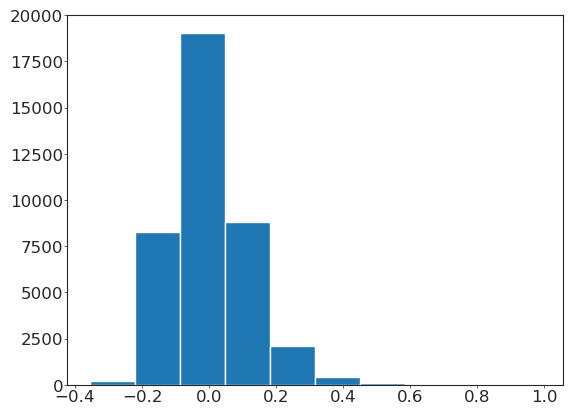

In [29]:
plt.hist(populationdata.flatten())

Now, we will visualize the full dataset to get a sense of what they look like. As mentioned previously, the first 100 features correspond to CS+ responses and the last 100 features correspond to CS- responses. So I will plot both trial types separately.

In [30]:
framerate = 1/BinSize
pre_window_size = int(0.5*TimeRange*framerate) # 3 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = TotalBins # Total number of frames plotted around a cue
frames_to_reward = int(0.5*TimeRange*framerate) # 3 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + frames_to_reward] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.4 # Maximum colormap value. 
cmin = -0.4

trial_types = ['PP', 'CP']

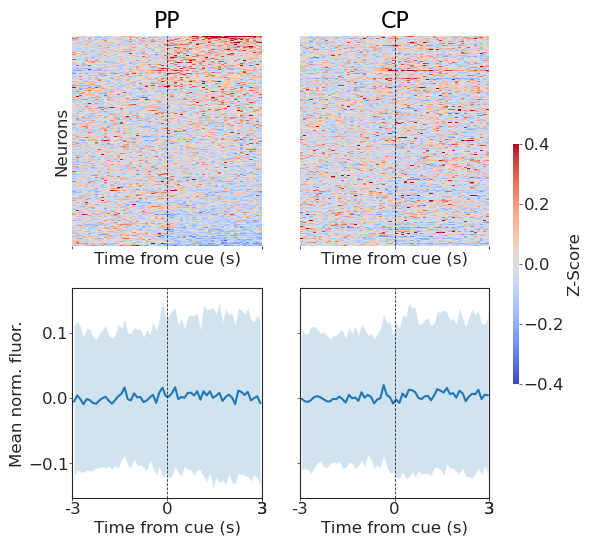

In [31]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'Z-Score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int((a - pre_window_size) / framerate)) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. fluor.')
#fig.tight_layout()
fig.subplots_adjust(right=0.82)

Including all 200 response features per neuron makes the feature space quite large. So, let us first reduce the dimensionality of this space using Principal Component Analysis

Number of PCs = 120
Number of PCs to keep = 9


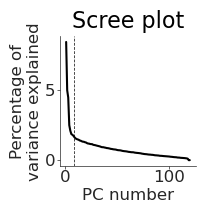

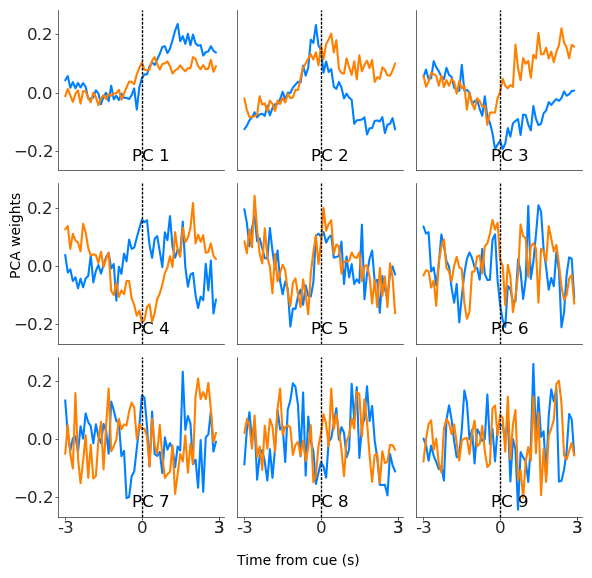

In [32]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
#xprime = (x - np.mean(x))/(np.max(x)-np.min(x))
num_retained_pcs = np.argmin(xprime) #np.min(np.where(np.cumsum(x)>50))+1  #np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
#ax.set_xlim([0,5])
[i.set_linewidth(0.5) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key['PP'] = (0,0.5,1)
colors_for_key['CP'] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    ax.annotate(text='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

## Perform clustering

Now, we have reduced the full dataset into a reduced dimensionality corresponding to the PCA subspace. 

Next, we will start the clustering. The approach we will use is Spectral Clustering. This is a pretty good method for dealing with high dimensional data. Note that even after PCA dimensionality reduction, there are 8 dimensions in this dataset. The choice of the method can affect the exact clustering results and there really is no "the best" algorithm. Thus, clustering is almost always the beginning of an investigation, rather than the end. In other words, the point of this clustering approach is not to say "There are 9 subpopulations of neurons in OFC for sure", but rather to test if these identified clusters can be mapped onto interesting features either in terms of their responses or in terms of their biological features (genes, anatomy etc).

The one issue with Spectral Clustering is that you have to pre-specify the number of clusters. However, there are ways to optimize this number by using metrics of "clusteredness". I use a common method: <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">silhouette score</a>. The one caveat of this method you need to specify a minimum of two clusters. In my experience, when the data truly do not contain any clusters, the minimum of two clusters identified will be quite obviously similar to each other. When data visualization clearly shows that the identified "clusters" are similar in terms of responses, one should conclude that there are no clusters.

This is the fundamental issue with approaches such as clustering. In the end, there are strong subjective elements to it. However, when there truly are clusters in the data, it can be a powerful approach to uncovering such structure. In my case, I validated these identified clusters using two major approaches:

1. I found that the responses of neurons that were clustered on one day are stable on another day when the behavior is stable. Thus, the difference between clusters remains even on a cross-validation day.

2. Subpopulations of the output population studied here (e.g. OFC neurons projecting to VTA or NAc) comprise of only select clusters. This shows that specific types of responses are absent in specific downstream projections. Such a clear mapping of identified clusters to biology is a good indication that the clustering results are real.

In [33]:
max_n_clusters = 8 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([10, 50, 100, 200, 300]) #np.array([100, 500, 1000, 2000, 4000]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)

Done with numclusters = 2, num nearest neighbors = 10: score = 0.152
Done with numclusters = 2, num nearest neighbors = 50: score = 0.157
Done with numclusters = 2, num nearest neighbors = 100: score = 0.159
Done with numclusters = 2, num nearest neighbors = 200: score = 0.138
Done with numclusters = 2, num nearest neighbors = 300: score = 0.021
Done with numclusters = 3, num nearest neighbors = 10: score = 0.138
Done with numclusters = 3, num nearest neighbors = 50: score = 0.149
Done with numclusters = 3, num nearest neighbors = 100: score = 0.149
Done with numclusters = 3, num nearest neighbors = 200: score = 0.101
Done with numclusters = 3, num nearest neighbors = 300: score = 0.030
Done with numclusters = 4, num nearest neighbors = 10: score = 0.120
Done with numclusters = 4, num nearest neighbors = 50: score = 0.149
Done with numclusters = 4, num nearest neighbors = 100: score = 0.145
Done with numclusters = 4, num nearest neighbors = 200: score = 0.103
Done with numclusters = 4,

Next, we will reorder the cluster labels such that there is a fixed order for naming the clusters. This is important because if you run the previous code multiple times, it will return different orders for the cluster labels.

In [34]:
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = transformed_data #np.load(os.path.join(basedir, 'OFCCaMKII_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])-np.mean(populationdata[rawlabels==label, window_size+pre_window_size:window_size+2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(basedir, 'OFCCaMKII_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

8 50
Number of clusters = 8, average silhouette = 0.166


Make a silhouette plot to visualize clustering quality. The average silhouette score above is the mean of all sample silhouettes. There are two other clustering methods commented out above (KMeans and agglomerative). One can see that if you apply those methods, the average silhouette score is lower, demonstrating that those methods are worse for these data. This also then shows that the high dimensional geometry for these data is unlikely to be a simple Gaussian structure, as these other methods are specialized for picking up Gaussian clusters. Spectral clustering is effective as it can uncover peculiarly shaped clusters

In [35]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

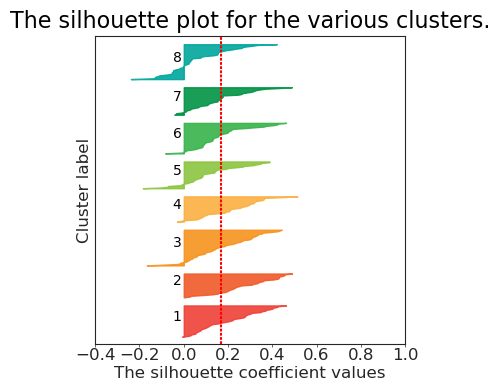

In [36]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

The average silhouette coefficient is about 0.2. As a general rule, this is a fairly low clustering quality index. However, if the range of spread of the data in the high dimensional space is fixed, silhouette score will necessarily be lower when there are many clusters in the data. Thus, this silhouette cannot by itself be used to argue against clustering in these data. This is why the clustering quality in this case needs to be verified through other means, such as projection specificity or response stability for clusters.

The neurons with negative silhouette scores are assigned to the wrong cluster. So one possible approach could be to run clustering multiple times (it's stochastic) and only select neurons that are reliably assigned to their corresponding cluster. This will improve cluster-wise inference for other analyses. However, I wanted to keep the analysis simpler and hence, decided not to do such filtering.

Plot the identified clusters. This plot is a good comparison to the original plot of the data, which did not cluster the data

In [37]:
population.to_csv("population_data_3_to_0.csv")

In [38]:
cluster_id = population
cluster_id.insert(1, 'Cluster', newlabels)
cluster_id = cluster_id.iloc[:,:2]
cluster_id.to_csv("cluster_id_3_to_0.csv")

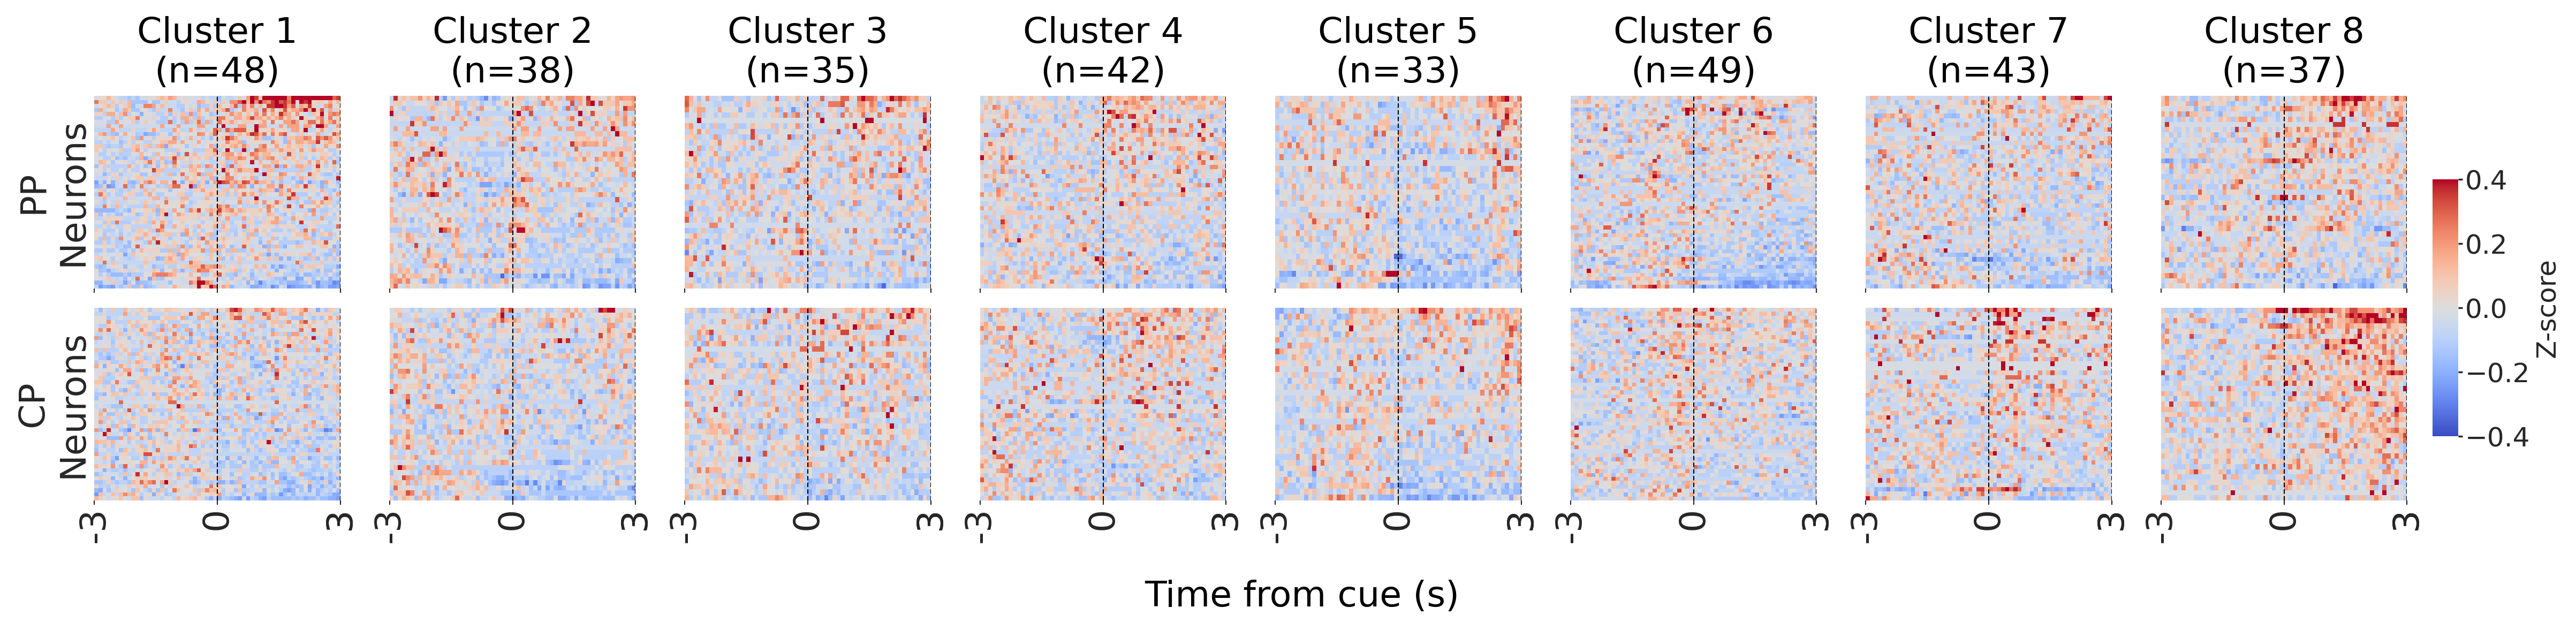

In [39]:
cmax = 0.4
cmin = -0.4
#sortwindow = [15, 100]
sortwindow = [pre_window_size+1, window_size]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)), dpi = 300)
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.8) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[k, cluster],
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=cmin,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Z-score'})
        axs[k, cluster].grid(False)
        if k==len(trial_types)-1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
            axs[k, cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        else:
            axs[k, cluster].set_xticks([])
        axs[k, cluster].tick_params(width=0.5, labelsize=16)
        axs[k, cluster].set_xticks([0, pre_window_size,
                            pre_window_size + frames_to_reward, window_size])

        
        axs[k, cluster].set_yticks([])
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[k, 0].set_ylabel('%s\nNeurons'%(tempkey), fontsize = 16)
    axs[0, cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=16,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.2, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

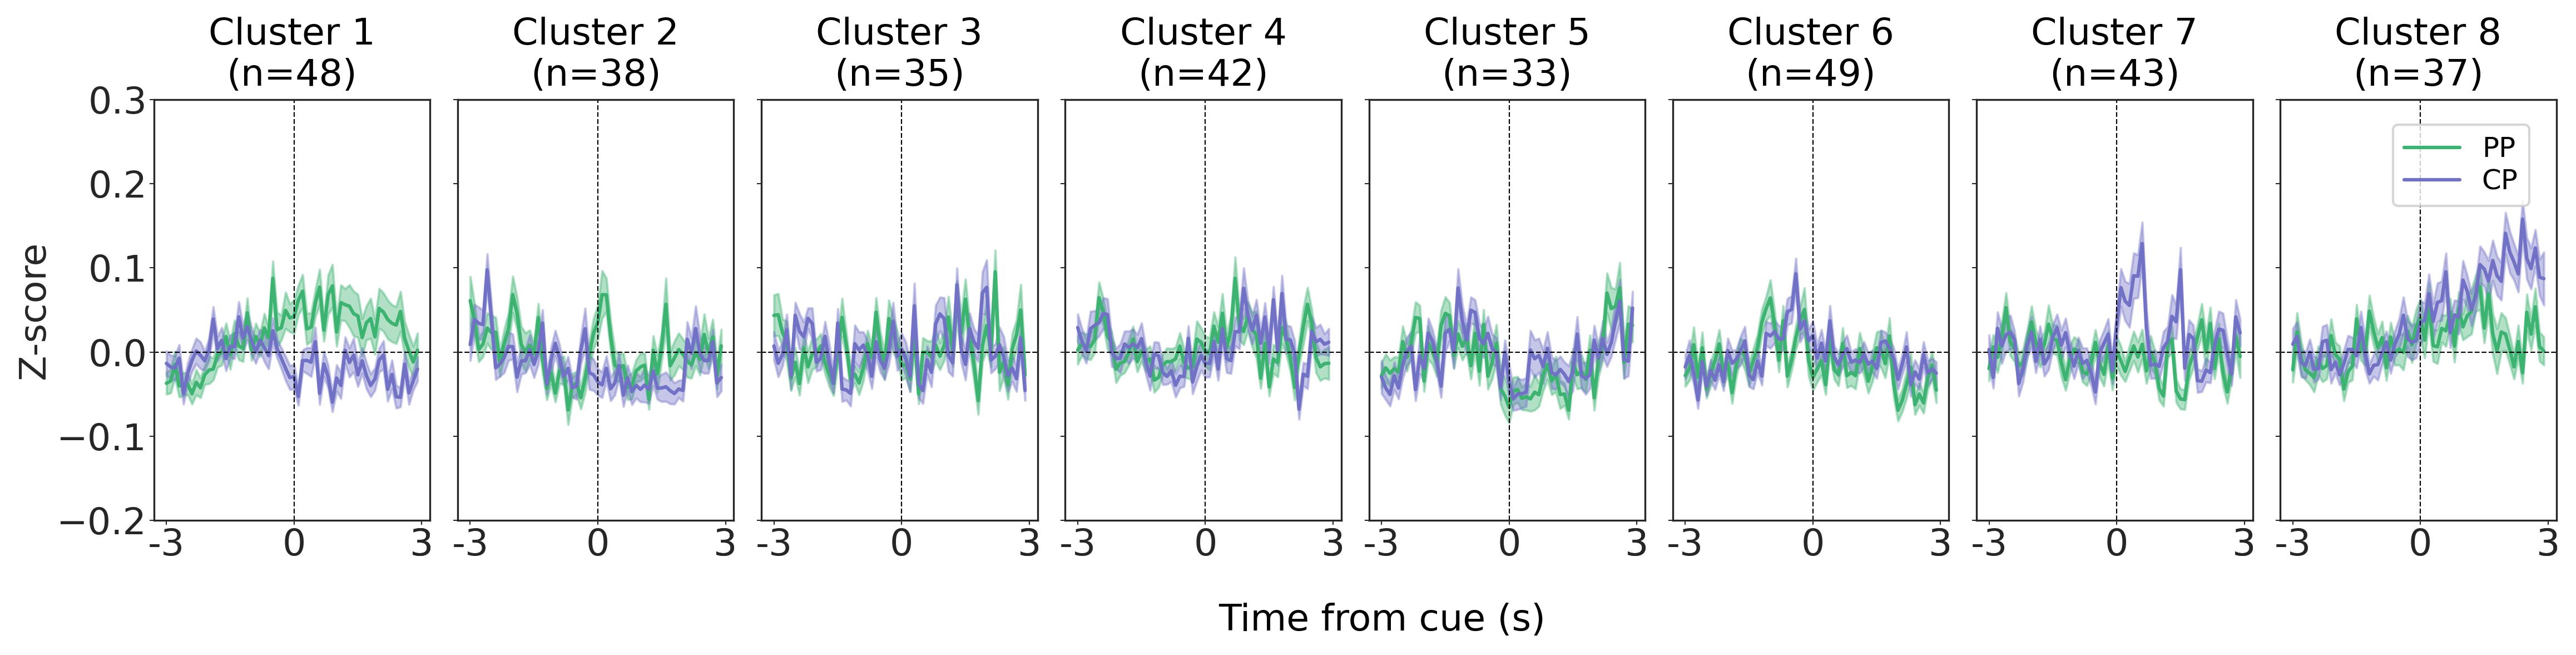

In [40]:
fig, axs = plt.subplots(1, len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)),dpi =300)

numroisincluster = np.nan * np.ones((len(uniquelabels),))
colors = ['mediumseagreen', '#7171C6']
trials = trial_types
lines = []

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Store the Line2D instances for creating the legend later
        line, = axs[cluster].plot(mean_temp, label= trials[k], color= colors[k])
        lines.append(line)

        axs[cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color=colors[k], alpha=0.4)

        #axs[cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[cluster].set_xticks([])

        axs[cluster].tick_params(width=0.5)
        axs[cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[cluster].set_ylim(-0.2,0.3)
        axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
        #axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster != 0:
            axs[cluster].set_yticklabels([])
        if cluster == 0:
            axs[0].set_ylabel('Z-score', fontsize = 16)
 
    axs[cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))
    axs[cluster].tick_params(labelsize=16)

# Create the legend at the end, outside of the loop
fig.legend(lines, trials,frameon = True, loc='lower right', bbox_to_anchor=(0.425, 0.65, 0.5, 0.5) )

fig.text(0.49, 0.05, 'Time from cue (s)', fontsize=16,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


Based on the responses of these identified clusters, the data do indeed look consistent with clustering. This is because the activity of neurons within a cluster look quite similar while activity across clusters looks quite different. As a further validation of the clustering, I will plot each neuron separated by clusters in the PCA space within which clustering was done.

Since there are 8 dimensions in the PCA space, I will use tSNE to reduce the dimensionality of this space to a 2D space. I will plot the tSNE transformation of the PCA scores of each pair of cluster against each other. If there are actually no real clusters, this plot will make it super clear. In this case, the default identified number of clusters will be two and in this plot, the two clusters will look like they belong to the same blob with an arbitrary line separating them. Instead, if there are real clusters, you will see different clusters forming different blobs when plotted against each other. 

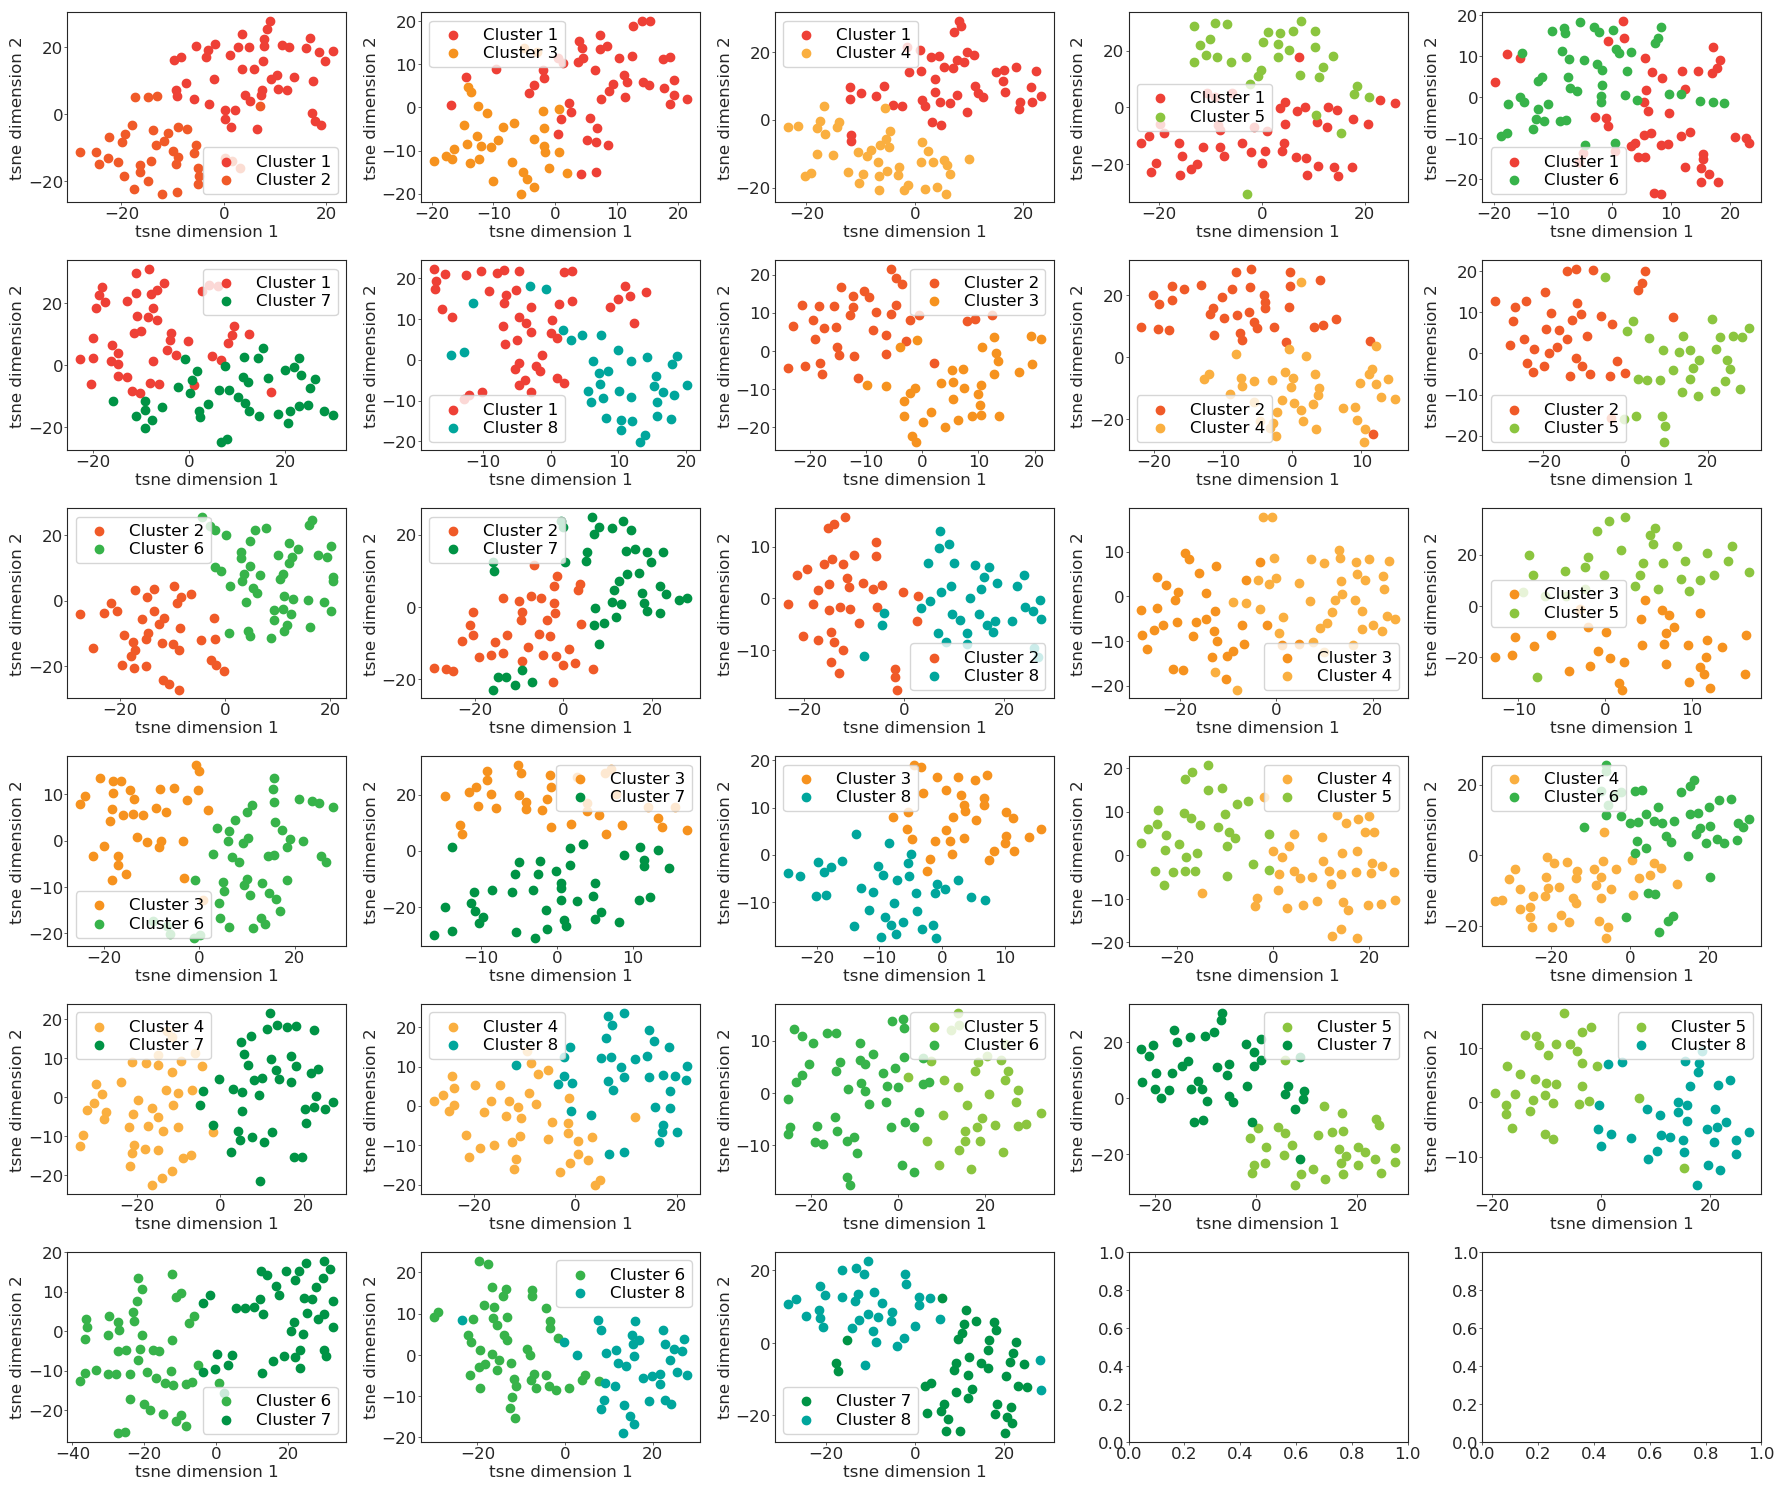

In [41]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=X.shape[1]-1)
        Y = tsne.fit_transform(X)
        if numrows * numcols == 1:
            ax = axs
        else:
            ax = axs[tempsum // numcols, tempsum - (tempsum // numcols) * numcols]


        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1
fig.tight_layout()

The above plot clearly shows that for most pairs of clusters, there is clear separability. In general, the only clusters with lowish separability are clusters 7, 8 and 9. It is possible that these are unresponsive neurons. A more "raw" way to plot the data is to actually plot different 2D views of the 8D PCA subspace. That approach gives clear indication of which PCA axes provide the best separation of individual pairs of clusters

## -3 to -2s (100ms bins)

**Below, the variable `populationdata` corresponds to the 4813 x 200 array, which pools all normalized PSTH fluorescence data across all neurons. We will first load this variable from the corresponding numpy file**

In [42]:
BinSize = 0.1
TimeRange = 6
TotalBins = int(TimeRange/BinSize)

baseline_start = 3
baseline_duration = 2

In [43]:
TotalBins

60

In [44]:
basedir = './' # folder containing code and data
Pref_Paired = pd.read_csv(os.path.join(basedir, 'Pref_Paired_new_zs_3_to_2.csv'), index_col = 0)
Confl_Paired = pd.read_csv(os.path.join(basedir, 'Confl_Paired_new_zs_3_to_2.csv'), index_col = 0)
Pref_Paired = Pref_Paired.replace([np.inf, -np.inf], np.nan)
Confl_Paired = Confl_Paired.replace([np.inf, -np.inf], np.nan)

population = Pref_Paired.merge(Confl_Paired, on=['Animal_ID', 'Unit_id'], how='left', indicator = True)

In [45]:
sum(population['_merge'] != 'both')

0

In [46]:
basedir = './' # folder containing code and data
Pref_Paired = pd.read_csv(os.path.join(basedir, 'Pref_Paired_new_zs_3_to_2.csv'), index_col = 0)
Confl_Paired = pd.read_csv(os.path.join(basedir, 'Confl_Paired_new_zs_3_to_2.csv'), index_col = 0)
Pref_Paired = Pref_Paired.replace([np.inf, -np.inf], np.nan)
Confl_Paired = Confl_Paired.replace([np.inf, -np.inf], np.nan)



In [47]:
population = Pref_Paired.merge(Confl_Paired, on=['Animal_ID', 'Unit_id'], how='left', indicator = True).dropna()
sum(population['_merge'] != 'both')

0

In [48]:

pref_paired = population.iloc[:,1:TotalBins+1].to_numpy()
confl_paired = population.iloc[:,TotalBins+1:2*TotalBins+1].to_numpy()

populationdata = np.concatenate([pref_paired,confl_paired],axis =1)

In [49]:
populationdata.shape

(324, 120)

In [50]:
populationdata.flatten().max()

1.0630559438235094

(array([1.2000e+02, 7.2900e+03, 2.0038e+04, 8.8120e+03, 2.0570e+03,
        4.3600e+02, 7.5000e+01, 2.8000e+01, 1.9000e+01, 5.0000e+00]),
 array([-0.38259521, -0.23803009, -0.09346498,  0.05110014,  0.19566525,
         0.34023037,  0.48479548,  0.6293606 ,  0.77392571,  0.91849083,
         1.06305594]),
 <BarContainer object of 10 artists>)

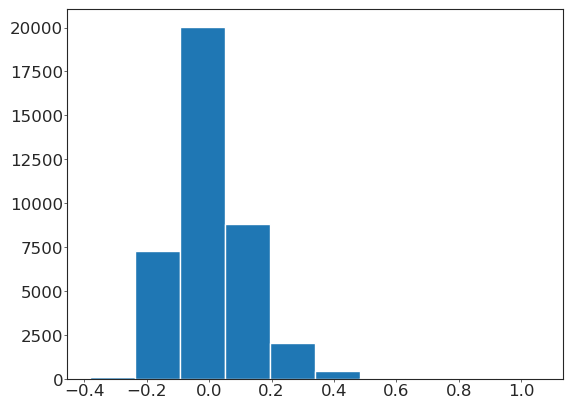

In [51]:
plt.hist(populationdata.flatten())

Now, we will visualize the full dataset to get a sense of what they look like. As mentioned previously, the first 100 features correspond to CS+ responses and the last 100 features correspond to CS- responses. So I will plot both trial types separately.

In [52]:
framerate = 1/BinSize
pre_window_size = int(0.5*TimeRange*framerate) # 3 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = TotalBins # Total number of frames plotted around a cue
frames_to_reward = int(0.5*TimeRange*framerate) # 3 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + frames_to_reward] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.4 # Maximum colormap value. 
cmin = -0.4

trial_types = ['PP', 'CP']

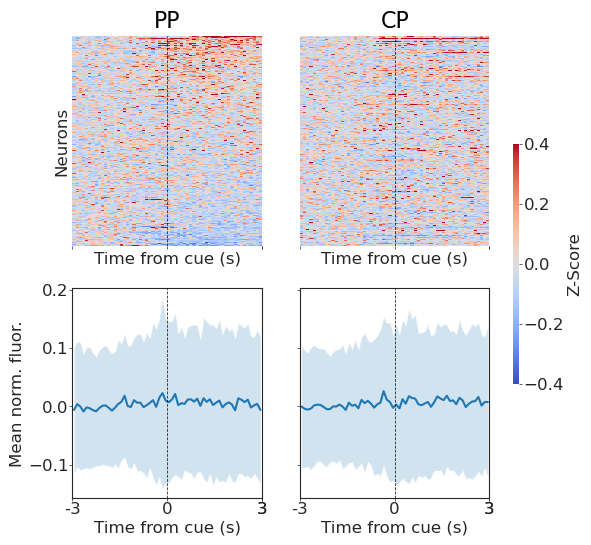

In [53]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'Z-Score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int((a - pre_window_size) / framerate)) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. fluor.')
#fig.tight_layout()
fig.subplots_adjust(right=0.82)

Including all 200 response features per neuron makes the feature space quite large. So, let us first reduce the dimensionality of this space using Principal Component Analysis

Number of PCs = 120
Number of PCs to keep = 6


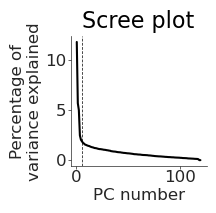

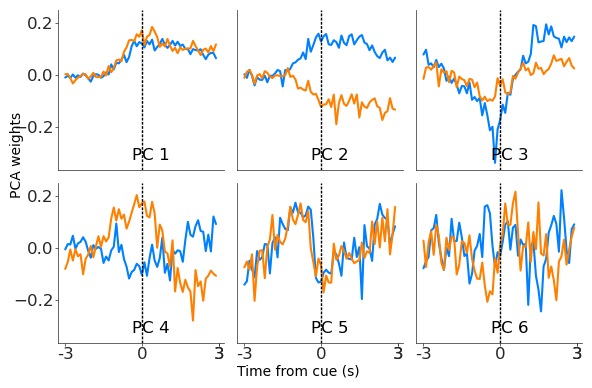

In [54]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
#xprime = (x - np.mean(x))/(np.max(x)-np.min(x))
num_retained_pcs = np.argmin(xprime)#np.min(np.where(np.cumsum(x)>50))+1  #np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
#ax.set_xlim([0,5])
[i.set_linewidth(0.5) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key['PP'] = (0,0.5,1)
colors_for_key['CP'] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    ax.annotate(text='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

## Perform clustering

Now, we have reduced the full dataset into a reduced dimensionality corresponding to the PCA subspace. 

Next, we will start the clustering. The approach we will use is Spectral Clustering. This is a pretty good method for dealing with high dimensional data. Note that even after PCA dimensionality reduction, there are 8 dimensions in this dataset. The choice of the method can affect the exact clustering results and there really is no "the best" algorithm. Thus, clustering is almost always the beginning of an investigation, rather than the end. In other words, the point of this clustering approach is not to say "There are 9 subpopulations of neurons in OFC for sure", but rather to test if these identified clusters can be mapped onto interesting features either in terms of their responses or in terms of their biological features (genes, anatomy etc).

The one issue with Spectral Clustering is that you have to pre-specify the number of clusters. However, there are ways to optimize this number by using metrics of "clusteredness". I use a common method: <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">silhouette score</a>. The one caveat of this method you need to specify a minimum of two clusters. In my experience, when the data truly do not contain any clusters, the minimum of two clusters identified will be quite obviously similar to each other. When data visualization clearly shows that the identified "clusters" are similar in terms of responses, one should conclude that there are no clusters.

This is the fundamental issue with approaches such as clustering. In the end, there are strong subjective elements to it. However, when there truly are clusters in the data, it can be a powerful approach to uncovering such structure. In my case, I validated these identified clusters using two major approaches:

1. I found that the responses of neurons that were clustered on one day are stable on another day when the behavior is stable. Thus, the difference between clusters remains even on a cross-validation day.

2. Subpopulations of the output population studied here (e.g. OFC neurons projecting to VTA or NAc) comprise of only select clusters. This shows that specific types of responses are absent in specific downstream projections. Such a clear mapping of identified clusters to biology is a good indication that the clustering results are real.

In [55]:
max_n_clusters = 8 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([10, 50, 100, 200, 300]) #np.array([100, 500, 1000, 2000, 4000]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)

Done with numclusters = 2, num nearest neighbors = 10: score = 0.232
Done with numclusters = 2, num nearest neighbors = 50: score = 0.248
Done with numclusters = 2, num nearest neighbors = 100: score = 0.251
Done with numclusters = 2, num nearest neighbors = 200: score = 0.245
Done with numclusters = 2, num nearest neighbors = 300: score = 0.017
Done with numclusters = 3, num nearest neighbors = 10: score = 0.217
Done with numclusters = 3, num nearest neighbors = 50: score = 0.240
Done with numclusters = 3, num nearest neighbors = 100: score = 0.241
Done with numclusters = 3, num nearest neighbors = 200: score = 0.201
Done with numclusters = 3, num nearest neighbors = 300: score = -0.083
Done with numclusters = 4, num nearest neighbors = 10: score = 0.220
Done with numclusters = 4, num nearest neighbors = 50: score = 0.234
Done with numclusters = 4, num nearest neighbors = 100: score = 0.231
Done with numclusters = 4, num nearest neighbors = 200: score = 0.166
Done with numclusters = 4

Next, we will reorder the cluster labels such that there is a fixed order for naming the clusters. This is important because if you run the previous code multiple times, it will return different orders for the cluster labels.

In [56]:
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = transformed_data #np.load(os.path.join(basedir, 'OFCCaMKII_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])-np.mean(populationdata[rawlabels==label, window_size+pre_window_size:window_size+2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(basedir, 'OFCCaMKII_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

6 50
Number of clusters = 6, average silhouette = 0.254


Make a silhouette plot to visualize clustering quality. The average silhouette score above is the mean of all sample silhouettes. There are two other clustering methods commented out above (KMeans and agglomerative). One can see that if you apply those methods, the average silhouette score is lower, demonstrating that those methods are worse for these data. This also then shows that the high dimensional geometry for these data is unlikely to be a simple Gaussian structure, as these other methods are specialized for picking up Gaussian clusters. Spectral clustering is effective as it can uncover peculiarly shaped clusters

In [57]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

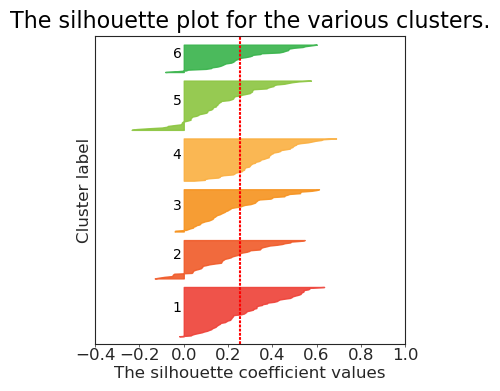

In [58]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

The average silhouette coefficient is about 0.2. As a general rule, this is a fairly low clustering quality index. However, if the range of spread of the data in the high dimensional space is fixed, silhouette score will necessarily be lower when there are many clusters in the data. Thus, this silhouette cannot by itself be used to argue against clustering in these data. This is why the clustering quality in this case needs to be verified through other means, such as projection specificity or response stability for clusters.

The neurons with negative silhouette scores are assigned to the wrong cluster. So one possible approach could be to run clustering multiple times (it's stochastic) and only select neurons that are reliably assigned to their corresponding cluster. This will improve cluster-wise inference for other analyses. However, I wanted to keep the analysis simpler and hence, decided not to do such filtering.

Plot the identified clusters. This plot is a good comparison to the original plot of the data, which did not cluster the data

In [59]:
population.to_csv("population_data_3_to_2.csv")

In [60]:
cluster_id = population
cluster_id.insert(1, 'Cluster', newlabels)
cluster_id = cluster_id.iloc[:,:2]
cluster_id.to_csv("cluster_id_3_to_2.csv")

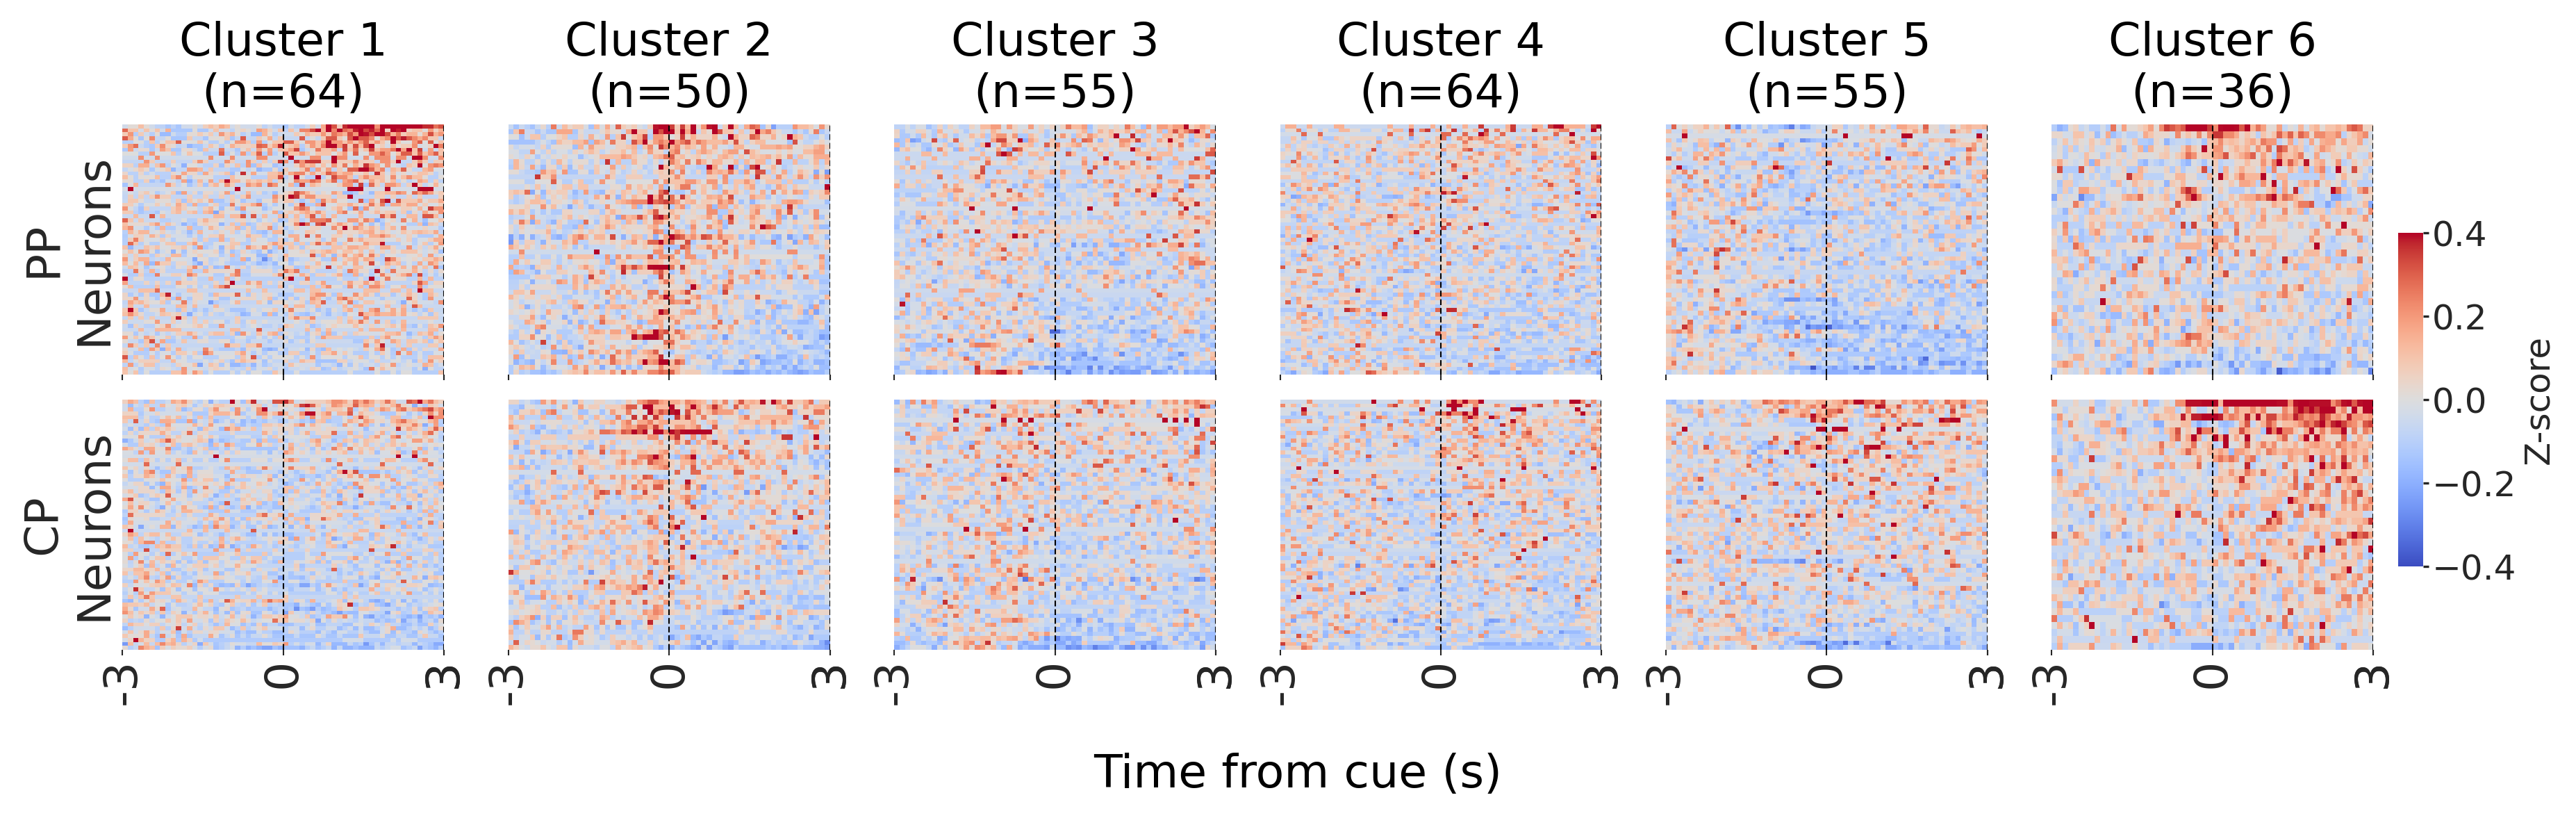

In [61]:
cmax = 0.4
cmin = -0.4
#sortwindow = [15, 100]
sortwindow = [pre_window_size+1, window_size]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)), dpi = 300)
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.8) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[k, cluster],
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=cmin,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Z-score'})
        axs[k, cluster].grid(False)
        if k==len(trial_types)-1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
            axs[k, cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        else:
            axs[k, cluster].set_xticks([])
        axs[k, cluster].tick_params(width=0.5, labelsize=16)
        axs[k, cluster].set_xticks([0, pre_window_size,
                            pre_window_size + frames_to_reward, window_size])

        
        axs[k, cluster].set_yticks([])
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[k, 0].set_ylabel('%s\nNeurons'%(tempkey), fontsize = 16)
    axs[0, cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=16,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.2, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

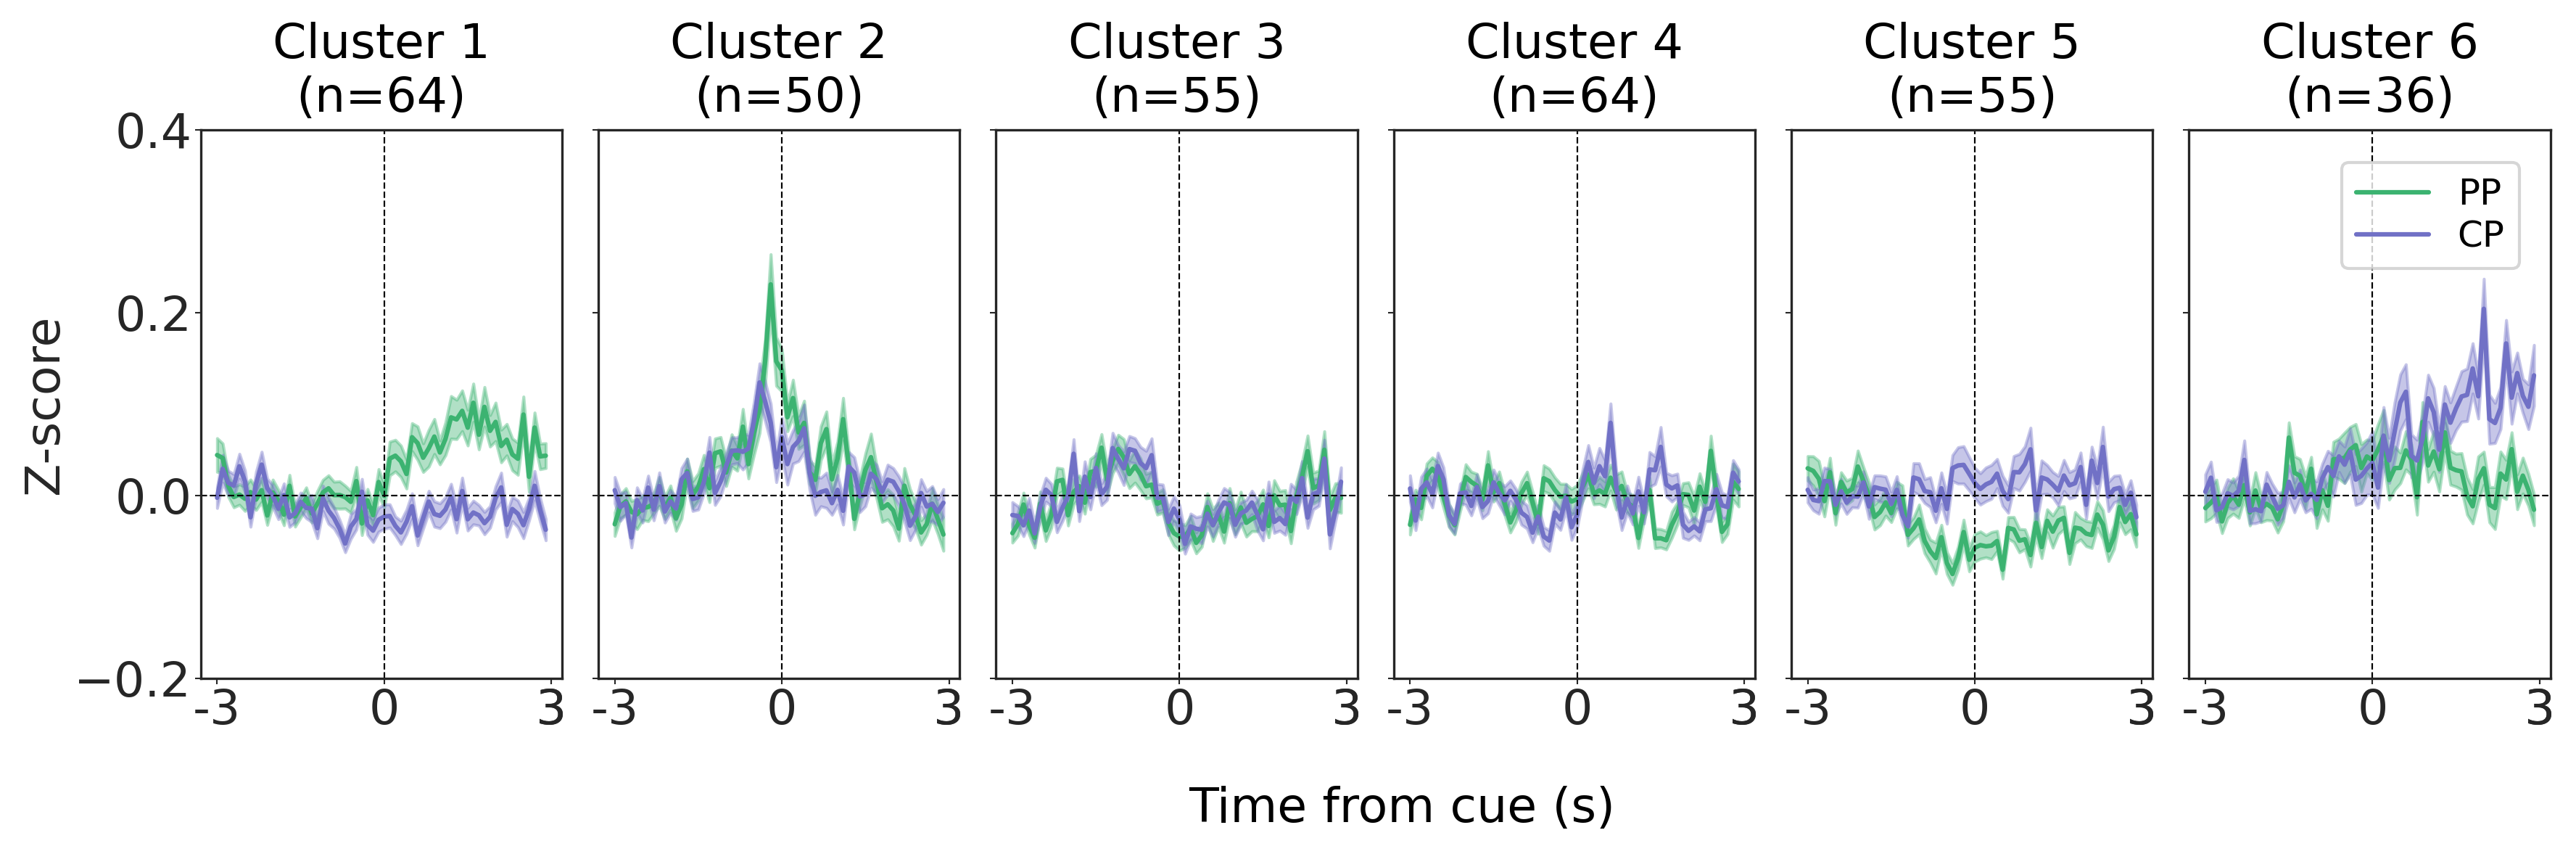

In [62]:
fig, axs = plt.subplots(1, len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)),dpi =300)

numroisincluster = np.nan * np.ones((len(uniquelabels),))
colors = ['mediumseagreen', '#7171C6']
trials = trial_types
lines = []

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Store the Line2D instances for creating the legend later
        line, = axs[cluster].plot(mean_temp, label= trials[k], color= colors[k])
        lines.append(line)

        axs[cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color=colors[k], alpha=0.4)

        #axs[cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[cluster].set_xticks([])

        axs[cluster].tick_params(width=0.5)
        axs[cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[cluster].set_ylim(-0.2,0.4)
        axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
        #axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster != 0:
            axs[cluster].set_yticklabels([])
        if cluster == 0:
            axs[0].set_ylabel('Z-score', fontsize = 16)
 
    axs[cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))
    axs[cluster].tick_params(labelsize=16)

# Create the legend at the end, outside of the loop
fig.legend(lines, trials,frameon = True, loc='lower right', bbox_to_anchor=(0.425, 0.65, 0.5, 0.5) )

fig.text(0.49, 0.05, 'Time from cue (s)', fontsize=16,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


Based on the responses of these identified clusters, the data do indeed look consistent with clustering. This is because the activity of neurons within a cluster look quite similar while activity across clusters looks quite different. As a further validation of the clustering, I will plot each neuron separated by clusters in the PCA space within which clustering was done.

Since there are 8 dimensions in the PCA space, I will use tSNE to reduce the dimensionality of this space to a 2D space. I will plot the tSNE transformation of the PCA scores of each pair of cluster against each other. If there are actually no real clusters, this plot will make it super clear. In this case, the default identified number of clusters will be two and in this plot, the two clusters will look like they belong to the same blob with an arbitrary line separating them. Instead, if there are real clusters, you will see different clusters forming different blobs when plotted against each other. 

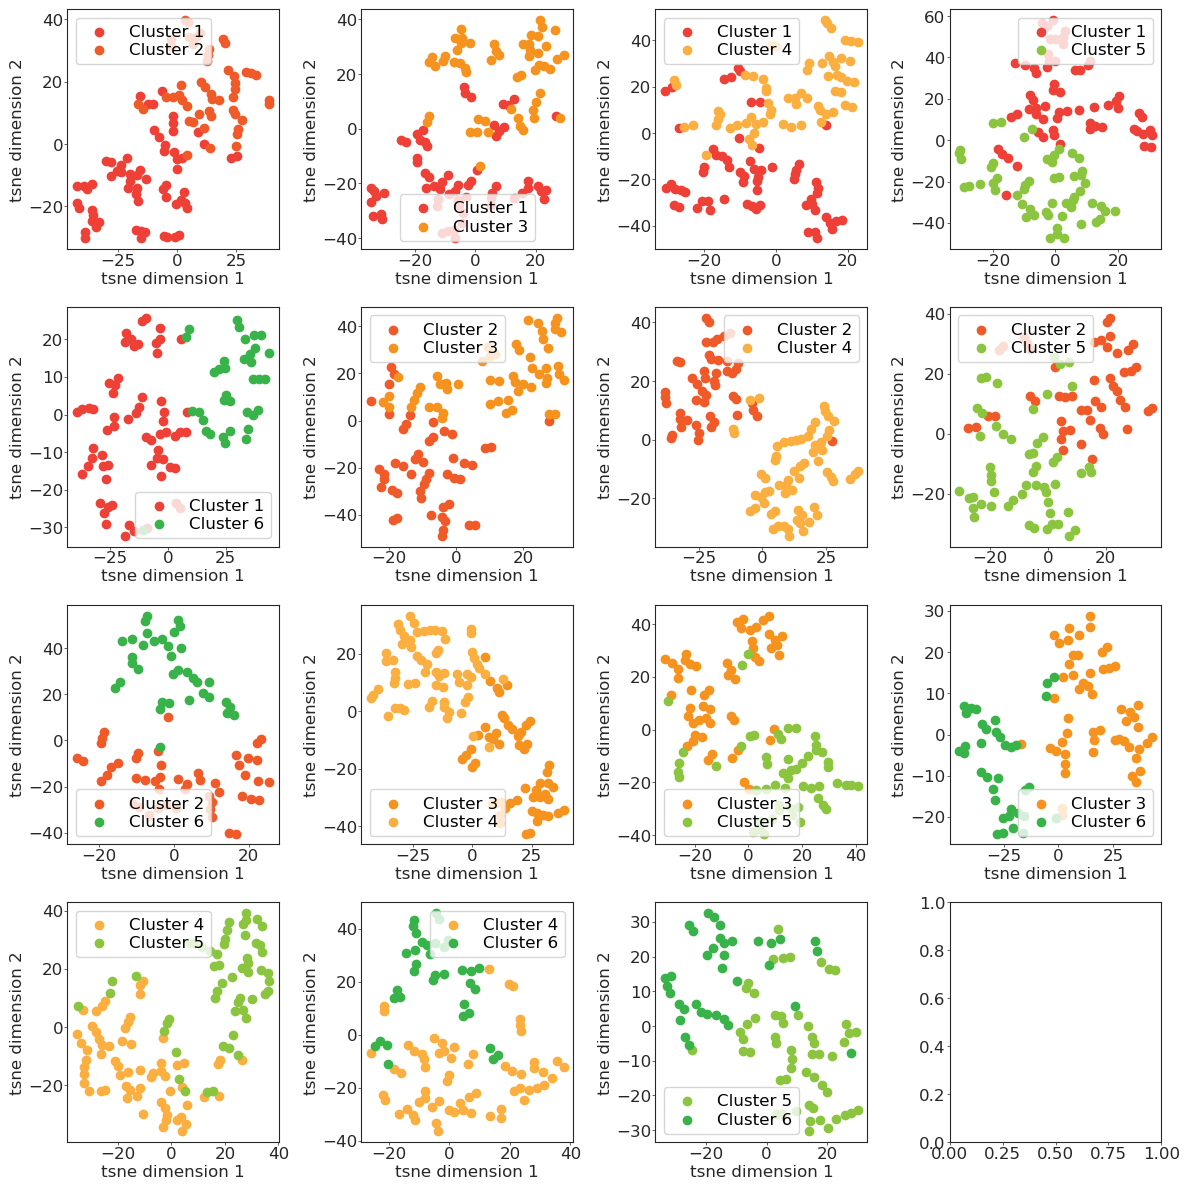

In [63]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=X.shape[1]-1)
        Y = tsne.fit_transform(X)
        if numrows * numcols == 1:
            ax = axs
        else:
            ax = axs[tempsum // numcols, tempsum - (tempsum // numcols) * numcols]


        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1
fig.tight_layout()

The above plot clearly shows that for most pairs of clusters, there is clear separability. In general, the only clusters with lowish separability are clusters 7, 8 and 9. It is possible that these are unresponsive neurons. A more "raw" way to plot the data is to actually plot different 2D views of the 8D PCA subspace. That approach gives clear indication of which PCA axes provide the best separation of individual pairs of clusters

## -3 to -1s (100ms bins)

**Below, the variable `populationdata` corresponds to the 4813 x 200 array, which pools all normalized PSTH fluorescence data across all neurons. We will first load this variable from the corresponding numpy file**

In [22]:
BinSize = 0.1
TimeRange = 6
TotalBins = int(TimeRange/BinSize)

baseline_start = 3
baseline_duration = 1

In [23]:
TotalBins

60

In [24]:
basedir = './' # folder containing code and data
Pref_Paired = pd.read_csv(os.path.join(basedir, 'Pref_Paired_new_zs_3_to_1.csv'), index_col = 0)
Confl_Paired = pd.read_csv(os.path.join(basedir, 'Confl_Paired_new_zs_3_to_1.csv'), index_col = 0)
Pref_Paired = Pref_Paired.replace([np.inf, -np.inf], np.nan)
Confl_Paired = Confl_Paired.replace([np.inf, -np.inf], np.nan)



In [25]:
population = Pref_Paired.merge(Confl_Paired, on=['Animal_ID', 'Unit_id'], how='left', indicator = True).dropna()
sum(population['_merge'] != 'both')

0

In [26]:

pref_paired = population.iloc[:,1:TotalBins+1].to_numpy()
confl_paired = population.iloc[:,TotalBins+1:2*TotalBins+1].to_numpy()

populationdata = np.concatenate([pref_paired,confl_paired],axis =1)

In [27]:
populationdata.shape

(319, 120)

In [28]:
populationdata.flatten().max()

1.3618257146597113

(array([1.5900e+02, 1.3116e+04, 1.8560e+04, 5.3330e+03, 8.5300e+02,
        1.8200e+02, 4.6000e+01, 2.2000e+01, 7.0000e+00, 2.0000e+00]),
 array([-0.40831773, -0.23130338, -0.05428904,  0.12272531,  0.29973965,
         0.47675399,  0.65376834,  0.83078268,  1.00779703,  1.18481137,
         1.36182571]),
 <BarContainer object of 10 artists>)

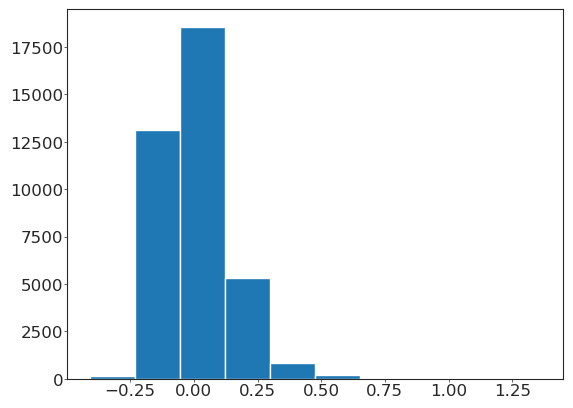

In [29]:
plt.hist(populationdata.flatten())

Now, we will visualize the full dataset to get a sense of what they look like. As mentioned previously, the first 100 features correspond to CS+ responses and the last 100 features correspond to CS- responses. So I will plot both trial types separately.

In [30]:
framerate = 1/BinSize
pre_window_size = int(0.5*TimeRange*framerate) # 3 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = TotalBins # Total number of frames plotted around a cue
frames_to_reward = int(0.5*TimeRange*framerate) # 3 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + frames_to_reward] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.4 # Maximum colormap value. 
cmin = -0.4

trial_types = ['PP', 'CP']

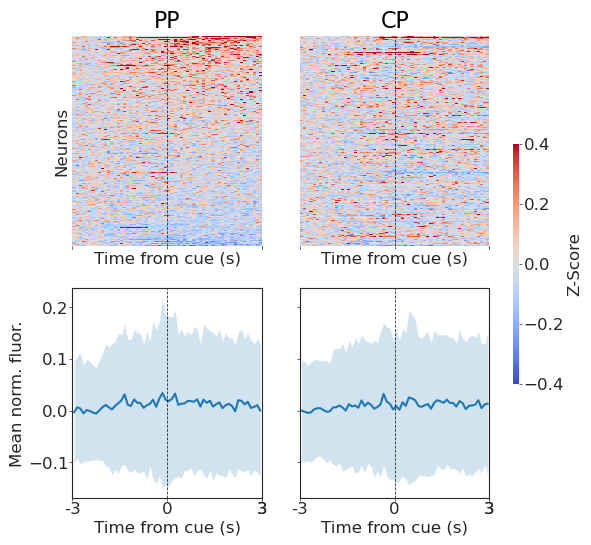

In [31]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'Z-Score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int((a - pre_window_size) / framerate)) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. fluor.')
#fig.tight_layout()
fig.subplots_adjust(right=0.82)

Including all 200 response features per neuron makes the feature space quite large. So, let us first reduce the dimensionality of this space using Principal Component Analysis

Number of PCs = 120
Number of PCs to keep = 6


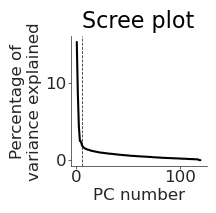

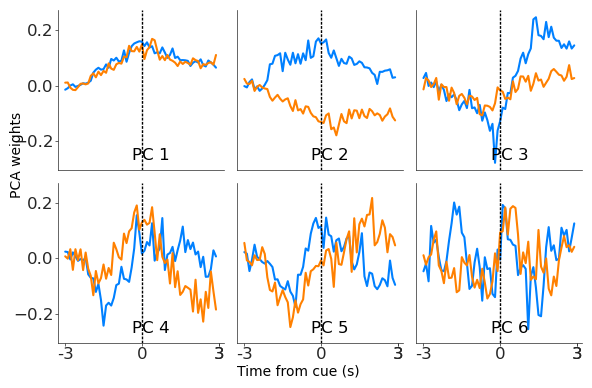

In [32]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
#xprime = (x - np.mean(x))/(np.max(x)-np.min(x))
num_retained_pcs = np.argmin(xprime)#np.min(np.where(np.cumsum(x)>50))+1  #np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
#ax.set_xlim([0,5])
[i.set_linewidth(0.5) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key['PP'] = (0,0.5,1)
colors_for_key['CP'] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    ax.annotate(text='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

## Perform clustering

Now, we have reduced the full dataset into a reduced dimensionality corresponding to the PCA subspace. 

Next, we will start the clustering. The approach we will use is Spectral Clustering. This is a pretty good method for dealing with high dimensional data. Note that even after PCA dimensionality reduction, there are 8 dimensions in this dataset. The choice of the method can affect the exact clustering results and there really is no "the best" algorithm. Thus, clustering is almost always the beginning of an investigation, rather than the end. In other words, the point of this clustering approach is not to say "There are 9 subpopulations of neurons in OFC for sure", but rather to test if these identified clusters can be mapped onto interesting features either in terms of their responses or in terms of their biological features (genes, anatomy etc).

The one issue with Spectral Clustering is that you have to pre-specify the number of clusters. However, there are ways to optimize this number by using metrics of "clusteredness". I use a common method: <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">silhouette score</a>. The one caveat of this method you need to specify a minimum of two clusters. In my experience, when the data truly do not contain any clusters, the minimum of two clusters identified will be quite obviously similar to each other. When data visualization clearly shows that the identified "clusters" are similar in terms of responses, one should conclude that there are no clusters.

This is the fundamental issue with approaches such as clustering. In the end, there are strong subjective elements to it. However, when there truly are clusters in the data, it can be a powerful approach to uncovering such structure. In my case, I validated these identified clusters using two major approaches:

1. I found that the responses of neurons that were clustered on one day are stable on another day when the behavior is stable. Thus, the difference between clusters remains even on a cross-validation day.

2. Subpopulations of the output population studied here (e.g. OFC neurons projecting to VTA or NAc) comprise of only select clusters. This shows that specific types of responses are absent in specific downstream projections. Such a clear mapping of identified clusters to biology is a good indication that the clustering results are real.

In [33]:
max_n_clusters = 8 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([10, 50, 100, 200, 300]) #np.array([100, 500, 1000, 2000, 4000]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)

Done with numclusters = 2, num nearest neighbors = 10: score = 0.230
Done with numclusters = 2, num nearest neighbors = 50: score = 0.230
Done with numclusters = 2, num nearest neighbors = 100: score = 0.232
Done with numclusters = 2, num nearest neighbors = 200: score = 0.232
Done with numclusters = 2, num nearest neighbors = 300: score = 0.031
Done with numclusters = 3, num nearest neighbors = 10: score = 0.215
Done with numclusters = 3, num nearest neighbors = 50: score = 0.223
Done with numclusters = 3, num nearest neighbors = 100: score = 0.234
Done with numclusters = 3, num nearest neighbors = 200: score = 0.186
Done with numclusters = 3, num nearest neighbors = 300: score = 0.022
Done with numclusters = 4, num nearest neighbors = 10: score = 0.231
Done with numclusters = 4, num nearest neighbors = 50: score = 0.241
Done with numclusters = 4, num nearest neighbors = 100: score = 0.245
Done with numclusters = 4, num nearest neighbors = 200: score = 0.180
Done with numclusters = 4,

Next, we will reorder the cluster labels such that there is a fixed order for naming the clusters. This is important because if you run the previous code multiple times, it will return different orders for the cluster labels.

In [34]:
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = transformed_data #np.load(os.path.join(basedir, 'OFCCaMKII_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])-np.mean(populationdata[rawlabels==label, window_size+pre_window_size:window_size+2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(basedir, 'OFCCaMKII_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

7 50
Number of clusters = 7, average silhouette = 0.271


Make a silhouette plot to visualize clustering quality. The average silhouette score above is the mean of all sample silhouettes. There are two other clustering methods commented out above (KMeans and agglomerative). One can see that if you apply those methods, the average silhouette score is lower, demonstrating that those methods are worse for these data. This also then shows that the high dimensional geometry for these data is unlikely to be a simple Gaussian structure, as these other methods are specialized for picking up Gaussian clusters. Spectral clustering is effective as it can uncover peculiarly shaped clusters

In [35]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

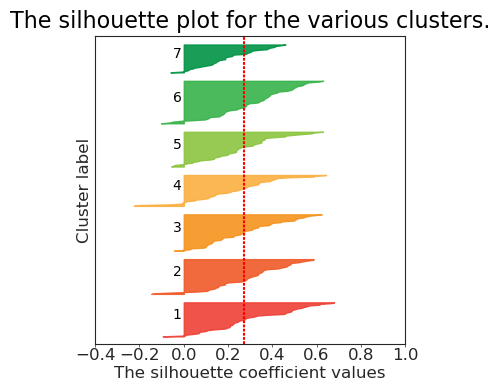

In [36]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

The average silhouette coefficient is about 0.2. As a general rule, this is a fairly low clustering quality index. However, if the range of spread of the data in the high dimensional space is fixed, silhouette score will necessarily be lower when there are many clusters in the data. Thus, this silhouette cannot by itself be used to argue against clustering in these data. This is why the clustering quality in this case needs to be verified through other means, such as projection specificity or response stability for clusters.

The neurons with negative silhouette scores are assigned to the wrong cluster. So one possible approach could be to run clustering multiple times (it's stochastic) and only select neurons that are reliably assigned to their corresponding cluster. This will improve cluster-wise inference for other analyses. However, I wanted to keep the analysis simpler and hence, decided not to do such filtering.

Plot the identified clusters. This plot is a good comparison to the original plot of the data, which did not cluster the data

In [39]:
np.savetxt("./Cana_CPP_Data/Results/population_data_3_to_1.csv", populationdata, delimiter=",")
np.savetxt("./Cana_CPP_Data/Results/newlabels_3_to_1.csv", newlabels, delimiter=",")

In [40]:
cluster_id = population.copy()
cluster_id.insert(1, 'Cluster', newlabels)
cluster_id = cluster_id.iloc[:,:2]
cluster_id.to_csv("./Cana_CPP_Data/Results/cluster_id_3_to_1.csv")

In [43]:
np.save("./Cana_CPP_Data/Results/transformed_data_3_to_1.npy", transformed_data)

In [41]:
populationdata = pd.read_csv("./Cana_CPP_Data/Results/population_data_3_to_1.csv", header = None).to_numpy()

In [42]:
populationdata

array([[ 2.12558003e-01, -7.08526676e-02, -7.08526676e-02, ...,
        -5.48271653e-02, -5.48271653e-02, -5.48271653e-02],
       [-6.33407309e-02, -6.33407309e-02,  9.50110964e-02, ...,
        -2.11899034e-17, -2.11899034e-17, -1.00453517e-01],
       [ 6.55189329e-02, -5.36063996e-02,  6.55189329e-02, ...,
         1.10772713e-01, -6.78929531e-02, -1.03626086e-01],
       ...,
       [-6.58891567e-02,  8.05311916e-02,  8.05311916e-02, ...,
        -5.41227138e-02, -1.31440876e-01,  2.31954488e-02],
       [ 2.12558003e-01, -7.08526676e-02, -7.08526676e-02, ...,
         5.10424508e-02, -3.40283006e-02, -1.19099052e-01],
       [ 1.04489391e-01,  3.91835215e-02, -2.61223477e-02, ...,
        -1.31440876e-01,  1.77831774e-01,  2.31954488e-02]])

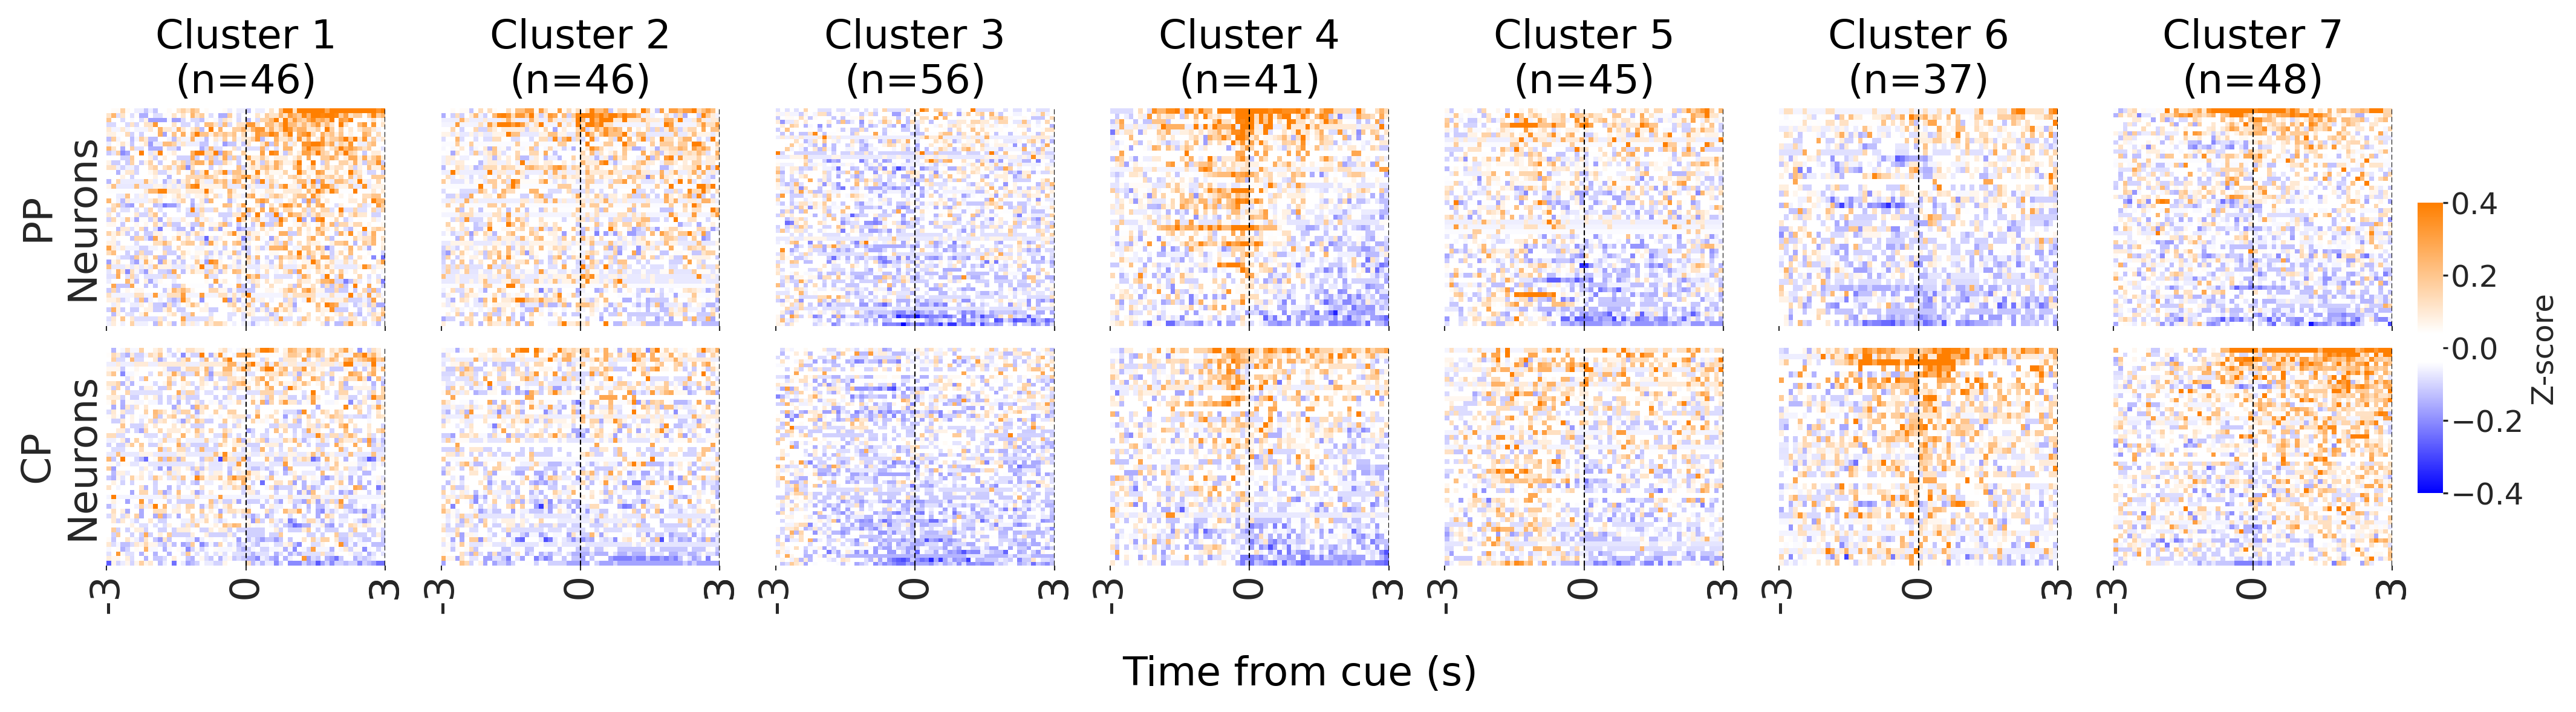

In [63]:
cmax = 0.4
cmin = -0.4
#sortwindow = [15, 100]
sortwindow = [pre_window_size+1, window_size]
colors = [(0.0, "blue"), (0.45, "white"), (0.55, "white"), (1.0, "#FF7F00")]
colormap = LinearSegmentedColormap.from_list("blue_white_orange", colors)


fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)), dpi = 300)
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.8) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[k, cluster],
                    cmap= colormap, #plt.get_cmap('coolwarm'),
                    vmin=cmin,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Z-score'})
        axs[k, cluster].grid(False)
        if k==len(trial_types)-1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
            axs[k, cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        else:
            axs[k, cluster].set_xticks([])
        axs[k, cluster].tick_params(width=0.5, labelsize=16)
        axs[k, cluster].set_xticks([0, pre_window_size,
                            pre_window_size + frames_to_reward, window_size])

        
        axs[k, cluster].set_yticks([])
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[k, 0].set_ylabel('%s\nNeurons'%(tempkey), fontsize = 16)
    axs[0, cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=16,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.2, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

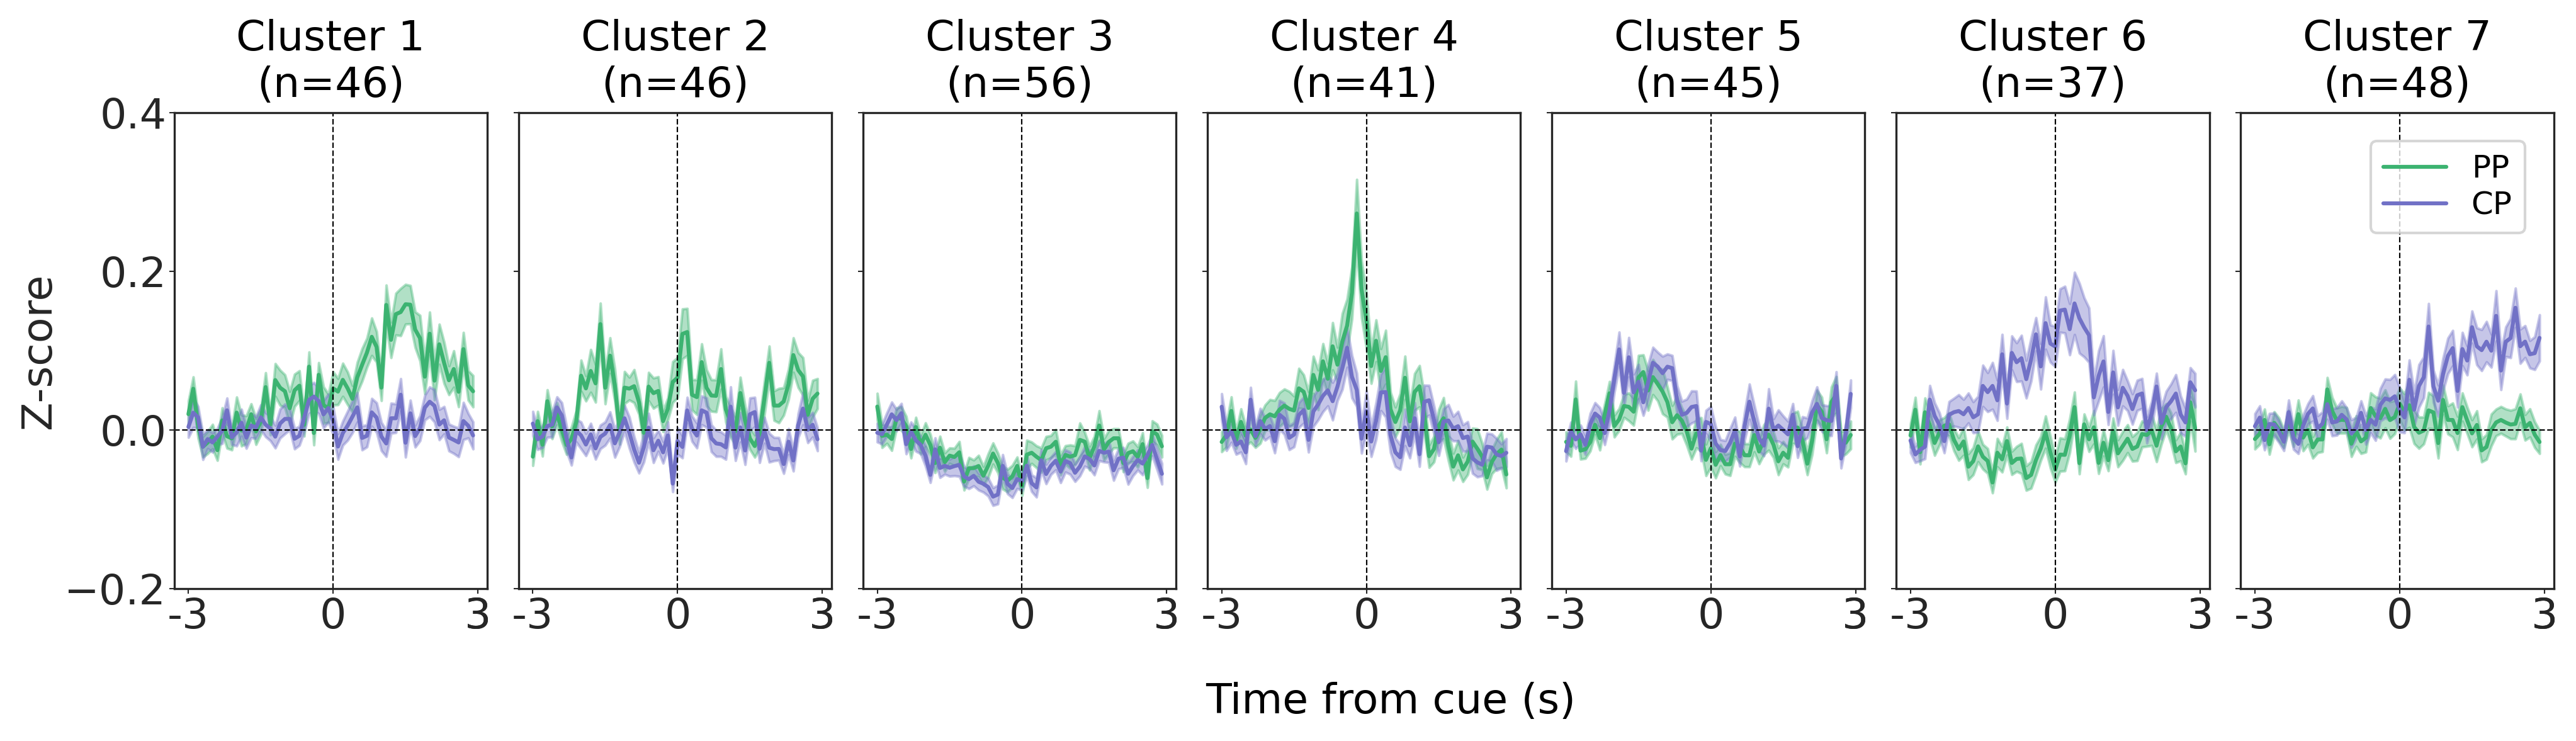

In [42]:
fig, axs = plt.subplots(1, len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)),dpi =300)

numroisincluster = np.nan * np.ones((len(uniquelabels),))
colors = ['mediumseagreen', '#7171C6']
trials = trial_types
lines = []

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Store the Line2D instances for creating the legend later
        line, = axs[cluster].plot(mean_temp, label= trials[k], color= colors[k])
        lines.append(line)

        axs[cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color=colors[k], alpha=0.4)

        #axs[cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[cluster].set_xticks([])

        axs[cluster].tick_params(width=0.5)
        axs[cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[cluster].set_ylim(-0.2,0.4)
        axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
        #axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster != 0:
            axs[cluster].set_yticklabels([])
        if cluster == 0:
            axs[0].set_ylabel('Z-score', fontsize = 16)
 
    axs[cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))
    axs[cluster].tick_params(labelsize=16)

# Create the legend at the end, outside of the loop
fig.legend(lines, trials,frameon = True, loc='lower right', bbox_to_anchor=(0.425, 0.65, 0.5, 0.5) )

fig.text(0.49, 0.05, 'Time from cue (s)', fontsize=16,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


Based on the responses of these identified clusters, the data do indeed look consistent with clustering. This is because the activity of neurons within a cluster look quite similar while activity across clusters looks quite different. As a further validation of the clustering, I will plot each neuron separated by clusters in the PCA space within which clustering was done.

Since there are 8 dimensions in the PCA space, I will use tSNE to reduce the dimensionality of this space to a 2D space. I will plot the tSNE transformation of the PCA scores of each pair of cluster against each other. If there are actually no real clusters, this plot will make it super clear. In this case, the default identified number of clusters will be two and in this plot, the two clusters will look like they belong to the same blob with an arbitrary line separating them. Instead, if there are real clusters, you will see different clusters forming different blobs when plotted against each other. 

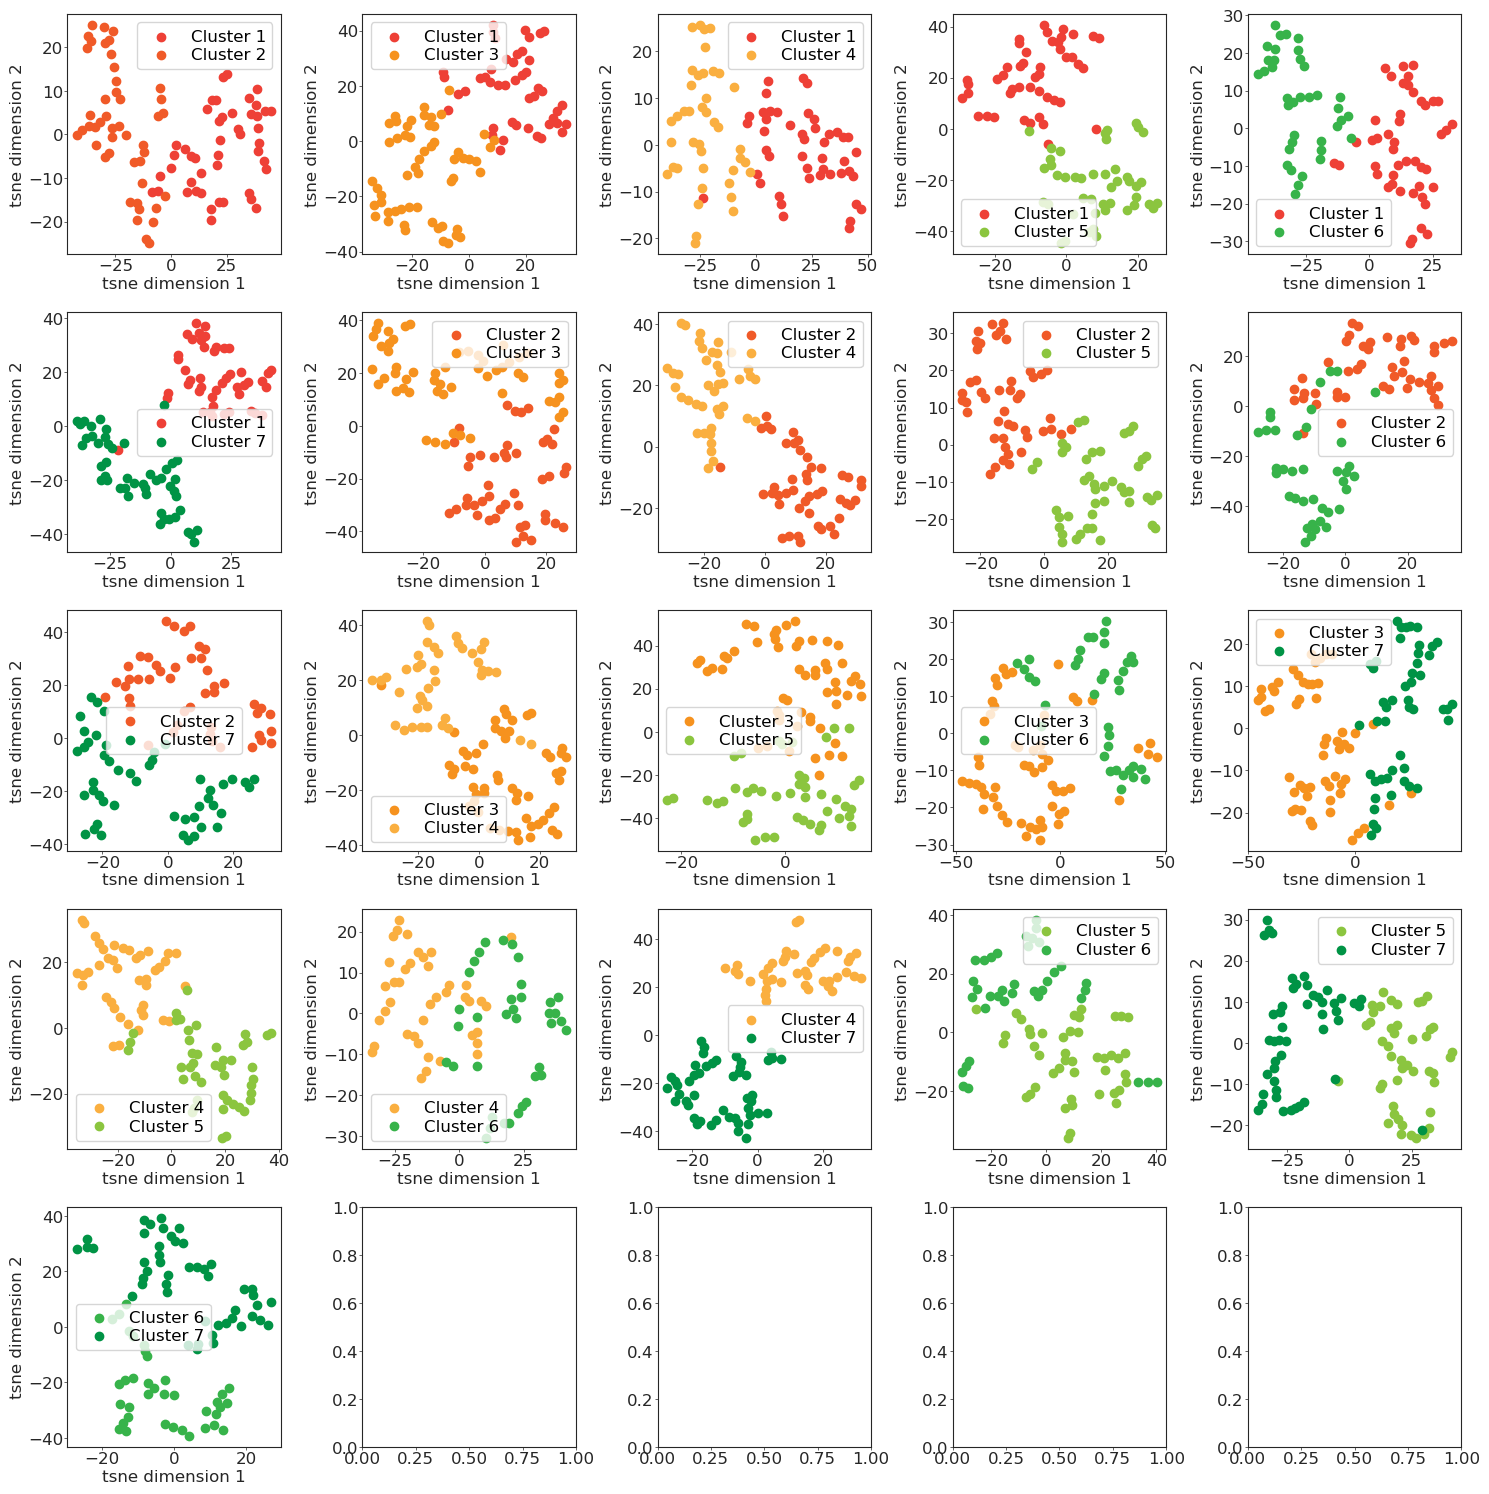

In [43]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=X.shape[1]-1)
        Y = tsne.fit_transform(X)
        if numrows * numcols == 1:
            ax = axs
        else:
            ax = axs[tempsum // numcols, tempsum - (tempsum // numcols) * numcols]


        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1
fig.tight_layout()

The above plot clearly shows that for most pairs of clusters, there is clear separability. In general, the only clusters with lowish separability are clusters 7, 8 and 9. It is possible that these are unresponsive neurons. A more "raw" way to plot the data is to actually plot different 2D views of the 8D PCA subspace. That approach gives clear indication of which PCA axes provide the best separation of individual pairs of clusters